**APRP: 4. Advanced Models: Variational Autoencoders and Generative Adversarial Networks**

**Contents:**

--------

**PART 1: Variational Autoencoders**
1. Short context
2. Understanding VAE details
3. Testing a different Prior
4. Comparing VAEs vs Autoencoders
5. Conditional VAEs


**PART 2: Generative Adversarial Networks**
1. Short context
2. Understanding vanilla GAN architecture details
3. Testing the Wasserstein-GAN

# **PART 1:  Variational Autoencoders**

### 1. Short context

In this assignment, the objective is to understand the Variational Autoencoder (VAE) architecture. Hence, we will start by interpreting the importance of the main components of this deep learning model. Afterwards, we will analyze the similarities and differences of VAEs with standard Autoencoders and, finally, implement a variant of the VAE, the conditional VAE.

### 2.	Implementing a standard Variational Autoencoder

#### 2.1. Introductory example using the MNIST dataset

In [72]:
import tensorflow as tf
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Lambda, Activation, LeakyReLU, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.callbacks import Callback,LearningRateScheduler

import numpy as np
import matplotlib.pyplot as plt
import torch

tf.compat.v1.disable_eager_execution()

def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype('float32') / 255.
    x_train = x_train[..., np.newaxis]
    x_test = x_test.astype('float32') / 255.
    x_test = x_test[..., np.newaxis]

    return (x_train, y_train), (x_test, y_test)

def exponential_decay_schedule(initial_lr=1e-3, decay_factor=0.9):
    """
    Wrapper function to create a LearningRateScheduler with exponential decay schedule.
    """
    def schedule(epoch):
        return initial_lr * decay_factor ** epoch

    return LearningRateScheduler(schedule)


class VariationalAutoencoder():
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size,
                 encoder_conv_strides, decoder_conv_t_filters, decoder_conv_t_kernel_size
                 , decoder_conv_t_strides, z_dim):

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self.build()

    def build(self):

        # ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            x = LeakyReLU()(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        encoder_output = Lambda(self.sampling, name='encoder_output')([self.mu, self.log_var])

        self.encoder = Model(encoder_input, encoder_output)


        # DECODER
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:

                x = LeakyReLU()(x)

            else:
                x = Activation('sigmoid')(x)

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

        # FULL VAE
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)

    def sampling(self,args):
        mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon

    def compile_model(self, learning_rate, r_loss_factor):
        self.learning_rate = learning_rate

        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
            return  r_loss  * r_loss_factor

        def vae_kl_loss(a, b):
            kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis = 1)
            return kl_loss

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return  r_loss + kl_loss

        optimizer = tf.keras.optimizers.legacy.Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer, loss = vae_loss, metrics = [vae_r_loss, vae_kl_loss])


    def train(self, x_train, batch_size, epochs, print_history_bool = True, lr_decay = 0.9):

        lr_sched = exponential_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay)

        callbacks_list = [lr_sched]

        history = self.model.fit(x_train, x_train, batch_size = batch_size, shuffle = True,
                       epochs = epochs, callbacks = callbacks_list)

        if print_history:
            plt.plot(history.history['loss'])
            plt.plot(history.history['vae_r_loss'])
            plt.plot(history.history['vae_kl_loss'])
            plt.title('Loss progression')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['VAE loss', 'Reconstruction', 'KL'], loc='upper right')
            plt.show()
        return history

Model: "model_36"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder_conv_0 (Conv2D)     (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 leaky_re_lu_84 (LeakyReLU)  (None, 28, 28, 32)           0         ['encoder_conv_0[0][0]']      
                                                                                                  
 encoder_conv_1 (Conv2D)     (None, 14, 14, 64)           18496     ['leaky_re_lu_84[0][0]']      
                                                                                           

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/adam.py:118: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Train on 60000 samples
Epoch 1/25
60000/60000 [==============================] - 11s 191us/sample - loss: 6.9752 - vae_r_loss: 6.8489 - vae_kl_loss: 0.1263 - lr: 5.0000e-04
Epoch 2/25
60000/60000 [==============================] - 11s 185us/sample - loss: 6.6969 - vae_r_loss: 6.4765 - vae_kl_loss: 0.2204 - lr: 4.5000e-04
Epoch 3/25
60000/60000 [==============================] - 12s 193us/sample - loss: 6.6944 - vae_r_loss: 6.4518 - vae_kl_loss: 0.2426 - lr: 4.0500e-04
Epoch 4/25
60000/60000 [==============================] - 11s 189us/sample - loss: 6.6878 - vae_r_loss: 6.4366 - vae_kl_loss: 0.2512 - lr: 3.6450e-04
Epoch 5/25
60000/60000 [==============================] - 11s 190us/sample - loss: 6.6883 - vae_r_loss: 6.4295 - vae_kl_loss: 0.2588 - lr: 3.2805e-04
Epoch 6/25
60000/60000 [==============================] - 11s 190us/sample - loss: 6.6842 - vae_r_loss: 6.4266 - vae_kl_loss: 0.2577 - lr: 2.9525e-04
Epoch 7/25
60000/60000 [==============================] - 13s 209us/sample - 

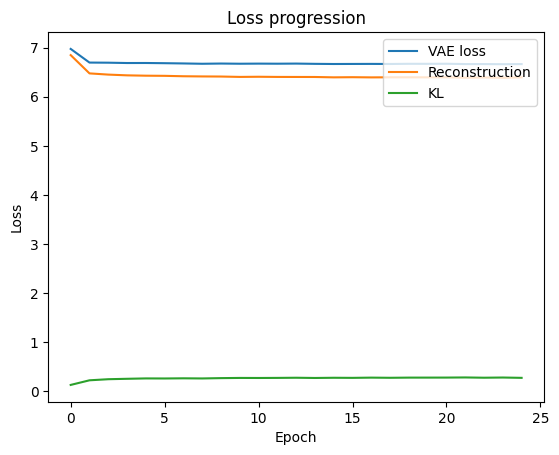

In [73]:
(x_train, y_train), (x_test, y_test) = load_mnist()


vae = VariationalAutoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64,64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

vae.encoder.summary()
vae.decoder.summary()

# Setting the parameters
learning_rate = 0.0005
reconstruction_loss_factor = 100
batch_size = 32
epochs = 25
print_history = True

vae.compile_model(learning_rate, reconstruction_loss_factor)

history = vae.train(x_train, batch_size = batch_size, epochs = epochs,
                     print_history_bool= print_history)


With the trained model, it is possible to sample reconstruct images by passing them through the enconder-decoder architecture:

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


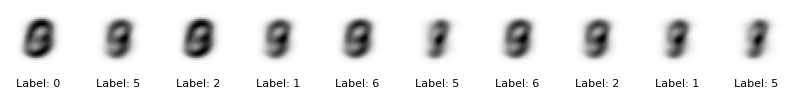

In [74]:
n_to_test = 10
example_idx = np.random.choice(range(len(x_test)), n_to_test)
example_images = x_test[example_idx]
example_labels = y_test[example_idx]
reconst = vae.model.predict(example_images)

fig = plt.figure(figsize=(10, 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_test):
    ax = fig.add_subplot(1, n_to_test, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'Label: '+str(example_labels[i]), fontsize=8, ha='center', transform=ax.transAxes)
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

### 2. Analysing the standard VAE
Based on the previously trained model provide the answer for the following questions:

**2.2.1** Generate 10 new data points randomly and reconstruct them using the previously trained Decoder model. Show the reconstructed output and comment the results.

**2.2.2.**	Explain the importance of parameter “reconstruction_loss_factor” in the VAE implementation. Apply a CallBack function employing a KL annealing strategy following this rule: B_new = B * (1 - baseline_B) + baseline_B, where **baseline_B** is a constant and **B** is updated throughout the training:


$$
\begin{align}
B = \frac{1}{{1 + e^{(\frac{\text{total_epochs}}{2} - \text{ current_epoch)}}}}
\end{align}
$$

Describe how this modification influences the obtained results.


2.2.1

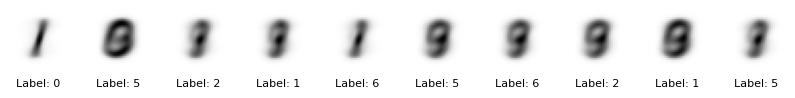

In [75]:
n_to_test = 10
z_dim = vae.z_dim
random_vectors = np.random.normal(0, 1, (n_to_test, z_dim))
reconst = vae.decoder.predict(random_vectors)

fig = plt.figure(figsize=(10, 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_test):
    ax = fig.add_subplot(1, n_to_test, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'Label: '+str(example_labels[i]), fontsize=8, ha='center', transform=ax.transAxes)
    ax.imshow(reconst[i, :,:,0], cmap = 'Greys')

2.2.2

In [76]:
class beta_scheduler(Callback):
    def __init__(self, baseline_beta, total_epochs=50):
        super(beta_scheduler, self).__init__()
        self.baseline_beta = baseline_beta
        self.total_epochs = total_epochs
        self.beta = baseline_beta

    def on_epoch_end(self, epoch, logs=None):
        beta = 1 / (1 * np.exp(self.total_epochs/2 - epoch))
        self.beta = beta * (1 - self.baseline_beta) + self.baseline_beta

class VariationalAutoencoderCallback():
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size,
                 encoder_conv_strides, decoder_conv_t_filters, decoder_conv_t_kernel_size
                 , decoder_conv_t_strides, z_dim):

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self.build()

    def build(self):

        # ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            x = LeakyReLU()(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)
        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        encoder_output = Lambda(self.sampling, name='encoder_output')([self.mu, self.log_var])

        self.encoder = Model(encoder_input, encoder_output)


        # DECODER
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:

                x = LeakyReLU()(x)

            else:
                x = Activation('sigmoid')(x)

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

        # FULL VAE
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)

    def sampling(self,args):
        mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon

    def compile_model(self, learning_rate, r_loss_factor, beta_scheduler):
        self.learning_rate = learning_rate

        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
            return  r_loss  * r_loss_factor

        def vae_kl_loss(a, b):
            kl_loss =  -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis = 1)
            return kl_loss * beta_scheduler.beta

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            kl_loss = vae_kl_loss(y_true, y_pred)
            return  r_loss + kl_loss

        optimizer = Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer, loss = vae_loss,  metrics = [vae_r_loss, vae_kl_loss])


    def train(self, x_train, batch_size, epochs, print_history_bool = True, lr_decay = 0.9):

        lr_sched = exponential_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay)

        callbacks_list = [lr_sched]

        history = self.model.fit(x_train, x_train, batch_size = batch_size, shuffle = True,
                       epochs = epochs, callbacks = callbacks_list)

        if print_history:
            plt.plot(history.history['loss'])
            plt.plot(history.history['vae_r_loss'])
            plt.plot(history.history['vae_kl_loss'])
            plt.title('Loss progression')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['VAE loss', 'Reconstruction', 'KL'], loc='upper right')
            plt.show()
        return history

Model: "model_39"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 encoder_input (InputLayer)  [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 encoder_conv_0 (Conv2D)     (None, 28, 28, 32)           320       ['encoder_input[0][0]']       
                                                                                                  
 leaky_re_lu_91 (LeakyReLU)  (None, 28, 28, 32)           0         ['encoder_conv_0[0][0]']      
                                                                                                  
 encoder_conv_1 (Conv2D)     (None, 14, 14, 64)           18496     ['leaky_re_lu_91[0][0]']      
                                                                                           

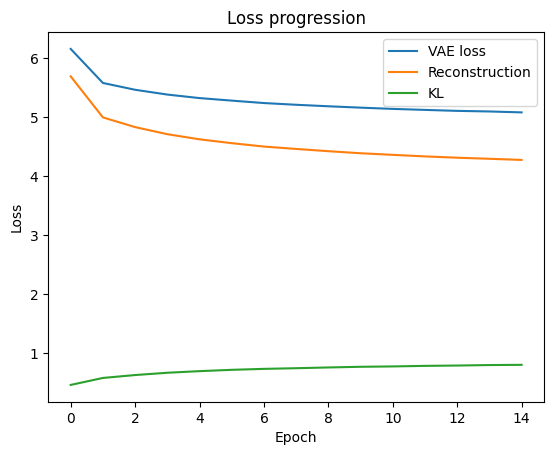

In [77]:
(x_train, y_train), (x_test, y_test) = load_mnist()


vaec = VariationalAutoencoderCallback(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64,64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
)

vaec.encoder.summary()
vaec.decoder.summary()

# Setting the parameters
learning_rate = 0.0005
reconstruction_loss_factor = 100
batch_size = 32
#epochs = 25
epochs = 15
print_history = True

b_scheduler = beta_scheduler(baseline_beta = 0.2, total_epochs = epochs)

vaec.compile_model(learning_rate, reconstruction_loss_factor, b_scheduler)

history = vaec.train(x_train, batch_size = batch_size, epochs = epochs,
                     print_history_bool= print_history)

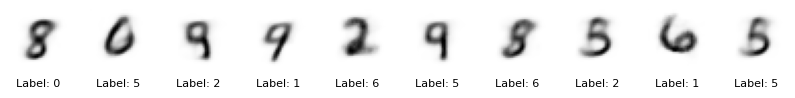

In [78]:
n_to_test = 10
z_dim = vaec.z_dim
random_vectors = np.random.normal(0, 1, (n_to_test, z_dim))
reconst = vaec.decoder.predict(random_vectors)

fig = plt.figure(figsize=(10, 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_test):
    ax = fig.add_subplot(1, n_to_test, i+1)
    ax.axis('off')
    ax.text(0.5, -0.35, 'Label: '+str(example_labels[i]), fontsize=8, ha='center', transform=ax.transAxes)
    ax.imshow(reconst[i, :, :, 0], cmap='Greys')

###**2.2.2.**

No VAE, o parâmetro "reconstruction_loss_factor" faz o controlo entre a perda de divergência KL (regularizar a distribuição latente aproximando-se de uma distribuição normal padrão) e a perda de reconstrução (determina quão bem o output decoded corresponde ao input original), no treino.

Os resultados obtidos são influenciados por esta modificação, visto que esta faz com que num estado inicial haja uma maior adequação da distribuição latente com a reconstrução. Com isto, num estado avançado o modelo pode-se focar mais em diminuir a perda de reconstrução.

### 3. VAE vs Autoencoder

The precursor to VAEs are simple autoencoders. However, autoencoders' primary function is to condense the information contained in the original input, allowing for an efficient dimensionality reduction.

**3.1.** Visualize and describe the latent space of the last version of the trained VAE by reconstructing 5000 randomly selected points from the test set.

**3.2.** Make the necessary changes to convert the VAE example into a standard autoencoder. Train the autoencoder, visualize the latent space, and randomly sample 10 instances from it. Describe the obtained results.  

3.1

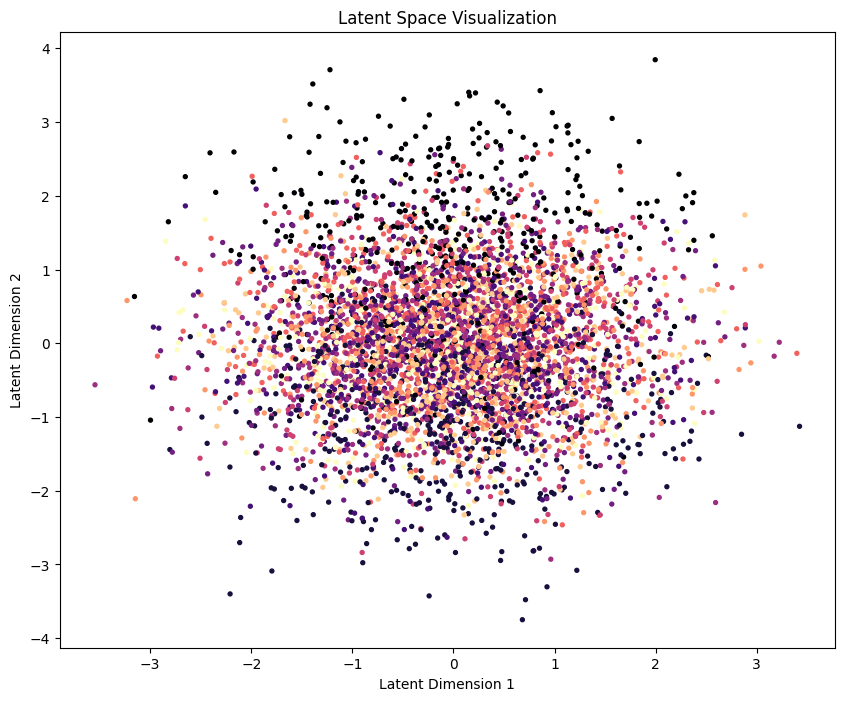

In [79]:
(x_train, y_train), (x_test, y_test) = load_mnist()

num_samples = 5000
random_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_test_subset = x_test[random_indices]
y_test_subset = y_test[random_indices]

latent= vae.encoder.predict(x_test_subset)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent[:, 0], latent[:, 1], c= y_test_subset, cmap='magma', s=8)
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()



Nesta visualização do espaço latente do Variational AutoEncoder conseguimos observar que não há muitos espaços em branco entre os vários pontos e que as classes não estão muito bem agrupadas, se conseguíssemos visualizar cada um dos pontos mais centrais, iríamos ver que passaríamos de um número para outro sem ter que percorrer muitos pontos. Obtemos também uma boa visão dos números em que conseguiríamos perceber qual número é.

3.2

In [80]:
tf.compat.v1.disable_eager_execution()

def load_mnist():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = x_train.astype('float32') / 255.
    x_train = x_train[..., np.newaxis]
    x_test = x_test.astype('float32') / 255.
    x_test = x_test[..., np.newaxis]

    return (x_train, y_train), (x_test, y_test)

def exponential_decay_schedule(initial_lr=1e-3, decay_factor=0.9):
    """
    Wrapper function to create a LearningRateScheduler with exponential decay schedule.
    """
    def schedule(epoch):
        return initial_lr * decay_factor ** epoch

    return LearningRateScheduler(schedule)


class Autoencoder():
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size,
                 encoder_conv_strides, decoder_conv_t_filters, decoder_conv_t_kernel_size
                 , decoder_conv_t_strides, z_dim):

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim

        self.n_layers_encoder = len(encoder_conv_filters)
        self.n_layers_decoder = len(decoder_conv_t_filters)

        self.build()

    def build(self):

        # ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')

        x = encoder_input

        for i in range(self.n_layers_encoder):
            conv_layer = Conv2D(
                filters = self.encoder_conv_filters[i]
                , kernel_size = self.encoder_conv_kernel_size[i]
                , strides = self.encoder_conv_strides[i]
                , padding = 'same'
                , name = 'encoder_conv_' + str(i)
                )

            x = conv_layer(x)

            x = LeakyReLU()(x)

        shape_before_flattening = K.int_shape(x)[1:]

        x = Flatten()(x)

        #self.mu = Dense(self.z_dim, name='mu')(x) #média
        #self.log_var = Dense(self.z_dim, name='log_var')(x) #desvio padrão

        encoder_output = x #Lambda(self.sampling, name='encoder_output')([self.mu, self.log_var])

        self.encoder = Model(encoder_input, encoder_output)


        # DECODER
        decoder_input = Input(shape=(x.shape[1],), name='decoder_input')

        x = Dense(np.prod(shape_before_flattening))(decoder_input)
        x = Reshape(shape_before_flattening)(x)

        for i in range(self.n_layers_decoder):
            conv_t_layer = Conv2DTranspose(
                filters = self.decoder_conv_t_filters[i]
                , kernel_size = self.decoder_conv_t_kernel_size[i]
                , strides = self.decoder_conv_t_strides[i]
                , padding = 'same'
                , name = 'decoder_conv_t_' + str(i)
                )

            x = conv_t_layer(x)

            if i < self.n_layers_decoder - 1:

                x = LeakyReLU()(x)

            else:
                x = Activation('sigmoid')(x)

        decoder_output = x

        self.decoder = Model(decoder_input, decoder_output)

        # FULL VAE
        model_input = encoder_input
        model_output = self.decoder(encoder_output)

        self.model = Model(model_input, model_output)

    def sampling(self,args):
        mu, log_var = args
        epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
        return mu + K.exp(log_var / 2) * epsilon

    def compile_model(self, learning_rate, r_loss_factor):
        self.learning_rate = learning_rate

        def vae_r_loss(y_true, y_pred):
            r_loss = K.mean(K.square(y_true - y_pred), axis = [1,2,3])
            return  r_loss  * r_loss_factor

        def vae_loss(y_true, y_pred):
            r_loss = vae_r_loss(y_true, y_pred)
            return  r_loss

        optimizer = tf.keras.optimizers.legacy.Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer, loss = vae_loss, metrics = [vae_r_loss])


    def train(self, x_train, batch_size, epochs, print_history_bool = True, lr_decay = 0.9):

        lr_sched = exponential_decay_schedule(initial_lr=self.learning_rate, decay_factor=lr_decay)

        callbacks_list = [lr_sched]

        history = self.model.fit(x_train, x_train, batch_size = batch_size, shuffle = True,
                       epochs = epochs, callbacks = callbacks_list)

        if print_history:
            plt.plot(history.history['loss'])
            plt.plot(history.history['vae_r_loss'])
            plt.title('Loss progression')
            plt.ylabel('Loss')
            plt.xlabel('Epoch')
            plt.legend(['VAE loss', 'Reconstruction'], loc='upper right')
            plt.show()
        return history

Model: "model_42"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 encoder_input (InputLayer)  [(None, 28, 28, 1)]       0         
                                                                 
 encoder_conv_0 (Conv2D)     (None, 28, 28, 32)        320       
                                                                 
 leaky_re_lu_98 (LeakyReLU)  (None, 28, 28, 32)        0         
                                                                 
 encoder_conv_1 (Conv2D)     (None, 14, 14, 64)        18496     
                                                                 
 leaky_re_lu_99 (LeakyReLU)  (None, 14, 14, 64)        0         
                                                                 
 encoder_conv_2 (Conv2D)     (None, 7, 7, 64)          36928     
                                                                 
 leaky_re_lu_100 (LeakyReLU  (None, 7, 7, 64)          0  

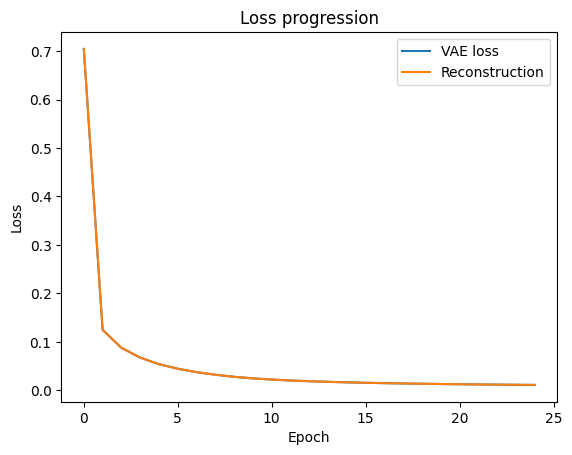

In [81]:
(x_train, y_train), (x_test, y_test) = load_mnist()


ae = Autoencoder(
    input_dim = (28,28,1)
    , encoder_conv_filters = [32,64,64,64]
    , encoder_conv_kernel_size = [3,3,3,3]
    , encoder_conv_strides = [1,2,2,1]
    , decoder_conv_t_filters = [64,64,32,1]
    , decoder_conv_t_kernel_size = [3,3,3,3]
    , decoder_conv_t_strides = [1,2,2,1]
    , z_dim = 2
    #x.shape()
)

ae.encoder.summary()
ae.decoder.summary()

# Setting the parameters
learning_rate = 0.0005
reconstruction_loss_factor = 100
batch_size = 32
epochs = 25
print_history = True

ae.compile_model(learning_rate, reconstruction_loss_factor)

history = ae.train(x_train, batch_size = batch_size, epochs = epochs,
                     print_history_bool= print_history)

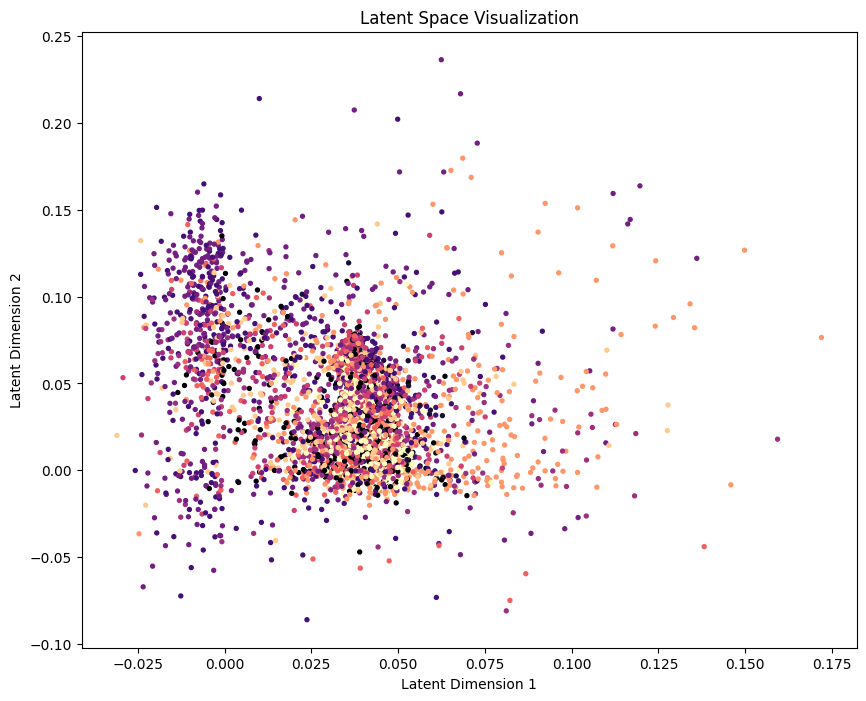

In [82]:
(x_train, y_train), (x_test, y_test) = load_mnist()

num_samples = 5000
random_indices = np.random.choice(x_test.shape[0], num_samples, replace=False)
x_test_subset = x_test[random_indices]
y_test_subset = y_test[random_indices]

latent= ae.encoder.predict(x_test_subset)

plt.figure(figsize=(10, 8))
scatter = plt.scatter(latent[:, 0], latent[:, 1], c= y_test_subset, cmap='magma', s=8)
plt.title('Latent Space Visualization')
plt.xlabel('Latent Dimension 1')
plt.ylabel('Latent Dimension 2')
plt.show()

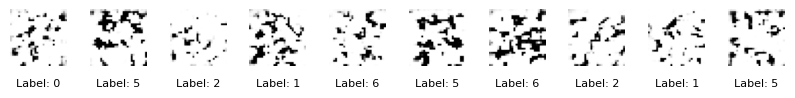

In [83]:
n_to_test = 10
z_dim = ae.z_dim
random_vectors = np.random.normal(size=(n_to_test, 3136))
reconst = ae.decoder.predict(random_vectors)

# visualizar as reconstruções
fig = plt.figure(figsize=(10, 2))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i in range(n_to_test):
    ax = fig.add_subplot(1, n_to_test, i+1)
    ax.text(0.5, -0.35, 'Label: '+str(example_labels[i]), fontsize=8, ha='center', transform=ax.transAxes)
    ax.axis('off')
    ax.imshow(reconst[i, :, :, 0], cmap='Greys')

Nesta visualização do espaço latente do AutoEncoder conseguimos ver que há mais espaços em branco e que enquanto que algumas classes estão mais agrupadas, há outras que estão mais espalhadas o que fará que, com a escolha de pontos aleatórios o resultado obtido seja o de cima, em que não conseguimos identificar nenhum número.

### 4. Interpolation of the VAE latent space

Interpolation involves generating new data points by smoothly transitioning between two existing data points in the latent space. Typically, it is achieved through linear combinations of their latent representations.

**4.1** Implement an interpolation example between two random latent vectors sampled from the latent space of the previously trained VAE. Display the intermediate images generated by decoding the interpolated latent vectors.

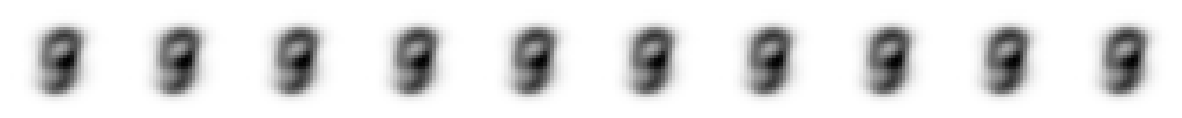

In [84]:
num_steps = 10
interpolation_steps = np.linspace(0,1,num_steps)
n_vectors = 2
latent_vectors = np.random.normal(size=(n_vectors, vae.z_dim))
interpolated_latent_vectors = []

for alpha in interpolation_steps:
  interpolated_latent_vector = alpha * latent_vectors[0] + (1- alpha) * latent_vectors[1]
  interpolated_latent_vectors.append(interpolated_latent_vector)

images = vae.decoder.predict(np.array(interpolated_latent_vectors))

fig, axes = plt.subplots(1, num_steps, figsize=(15, 2))
for i, img in enumerate(images):
    axes[i].imshow(img,cmap='Greys')
    axes[i].axis('off')

plt.show()

### 5. Conditional VAE

The conditional Variational Autoencoder (cVAE) is an extension of the standard VAE that incorporates additional conditional information during the encoding and decoding processes. It conditions the latent space on external information, allowing for more controlled and targeted generation of data by considering specific characteristics (label of each instance, for example) as input during both training and generation phases.


**5.1.** Implement and train a conditional VAE model, applying the necessary changes to the example architecture.

In [85]:
class ConditionalVariationalAutoencoder():
    def __init__(self, input_dim, encoder_conv_filters, encoder_conv_kernel_size,
                 encoder_conv_strides, decoder_conv_t_filters, decoder_conv_t_kernel_size,
                 decoder_conv_t_strides, z_dim, num_labels):

        self.input_dim = input_dim
        self.encoder_conv_filters = encoder_conv_filters
        self.encoder_conv_kernel_size = encoder_conv_kernel_size
        self.encoder_conv_strides = encoder_conv_strides
        self.decoder_conv_t_filters = decoder_conv_t_filters
        self.decoder_conv_t_kernel_size = decoder_conv_t_kernel_size
        self.decoder_conv_t_strides = decoder_conv_t_strides
        self.z_dim = z_dim
        self.num_labels = num_labels

        self._build()

    def _build(self):

        # ENCODER
        encoder_input = Input(shape=self.input_dim, name='encoder_input')
        labels_input = Input(shape=(self.num_labels,), name='labels_input')

        x = encoder_input
        # Converter etiquetas para uma forma compatível e concatená-las com a entrada
        labels_dense = Dense(np.prod(self.input_dim), activation='relu')(labels_input)
        labels_reshaped = Reshape(self.input_dim)(labels_dense)
        x = Concatenate(axis=-1)([x, labels_reshaped])

        for i in range(len(self.encoder_conv_filters)):
            x = Conv2D(filters=self.encoder_conv_filters[i], kernel_size=self.encoder_conv_kernel_size[i],
                       strides=self.encoder_conv_strides[i], padding='same', name='encoder_conv_' + str(i))(x)
            x = LeakyReLU()(x)

        shape_before_flattening = K.int_shape(x)[1:]
        x = Flatten()(x)

        self.mu = Dense(self.z_dim, name='mu')(x)
        self.log_var = Dense(self.z_dim, name='log_var')(x)

        def sampling(args):
            mu, log_var = args
            epsilon = K.random_normal(shape=K.shape(mu), mean=0., stddev=1.)
            return mu + K.exp(log_var / 2) * epsilon

        encoder_output = Lambda(sampling, name='encoder_output')([self.mu, self.log_var])

        self.encoder = Model([encoder_input, labels_input], encoder_output, name='encoder')

        # DECODER
        decoder_input = Input(shape=(self.z_dim,), name='decoder_input')
        labels_input_decoder = Input(shape=(self.num_labels,), name='labels_input_decoder')

        x = Concatenate()([decoder_input, labels_input_decoder])
        x = Dense(np.prod(shape_before_flattening), activation='relu')(x)
        x = Reshape(shape_before_flattening)(x)

        for i in range(len(self.decoder_conv_t_filters)):
            x = Conv2DTranspose(filters=self.decoder_conv_t_filters[i], kernel_size=self.decoder_conv_t_kernel_size[i],
                                strides=self.decoder_conv_t_strides[i], padding='same', name='decoder_conv_t_' + str(i))(x)
            if i < len(self.decoder_conv_t_filters) - 1:
                x = LeakyReLU()(x)
            else:
                x = Activation('sigmoid')(x)

        decoder_output = x
        self.decoder = Model([decoder_input, labels_input_decoder], decoder_output, name='decoder')

        # CONDITIONAL VAE MODEL
        model_input = [encoder_input, labels_input]
        model_output = self.decoder([encoder_output, labels_input])
        self.model = Model(model_input, model_output, name='cvae')

    def compile_model(self, learning_rate=0.0005):
        self.learning_rate = learning_rate

        def vae_r_loss(y_true, y_pred):
            return K.mean(K.square(y_true - y_pred), axis = [1,2,3])

        def vae_kl_loss(y_true, y_pred):
            return -0.5 * K.sum(1 + self.log_var - K.square(self.mu) - K.exp(self.log_var), axis=1)

        def vae_loss(y_true, y_pred):
            return vae_r_loss(y_true, y_pred) + vae_kl_loss(y_true, y_pred)

        optimizer = Adam(lr=learning_rate)
        self.model.compile(optimizer=optimizer, loss=vae_loss, metrics=[vae_r_loss, vae_kl_loss])

In [86]:
(x_train, y_train_original), (x_test, y_test_original) = mnist.load_data()

x_train = x_train.astype('float32') / 255.0
x_train = np.expand_dims(x_train, axis=-1)

y_train = to_categorical(y_train_original, num_classes=10)

cvae = ConditionalVariationalAutoencoder(
    input_dim=(28, 28, 1),
    encoder_conv_filters=[32, 64, 64, 64],
    encoder_conv_kernel_size=[3, 3, 3, 3],
    encoder_conv_strides=[1, 2, 2, 1],
    decoder_conv_t_filters=[64, 64, 32, 1],
    decoder_conv_t_kernel_size=[3, 3, 3, 3],
    decoder_conv_t_strides=[1, 2, 2, 1],
    z_dim=2,
    num_labels=10
)

cvae.compile_model(learning_rate=0.0005)

cvae.model.fit([x_train, y_train], x_train, epochs=15, batch_size=32)

Train on 60000 samples
Epoch 1/15
60000/60000 [==============================] - 12s 201us/sample - loss: 0.0580 - vae_r_loss: 0.0580 - vae_kl_loss: 9.4385e-06
Epoch 2/15
60000/60000 [==============================] - 13s 209us/sample - loss: 0.0536 - vae_r_loss: 0.0536 - vae_kl_loss: 3.0913e-07
Epoch 3/15
60000/60000 [==============================] - 12s 196us/sample - loss: 0.0536 - vae_r_loss: 0.0536 - vae_kl_loss: 2.0981e-07
Epoch 4/15
60000/60000 [==============================] - 12s 196us/sample - loss: 0.0535 - vae_r_loss: 0.0535 - vae_kl_loss: 1.5042e-07
Epoch 5/15
60000/60000 [==============================] - 12s 196us/sample - loss: 0.0535 - vae_r_loss: 0.0535 - vae_kl_loss: 1.1515e-07
Epoch 6/15
60000/60000 [==============================] - 12s 196us/sample - loss: 0.0535 - vae_r_loss: 0.0535 - vae_kl_loss: 1.0748e-07
Epoch 7/15
60000/60000 [==============================] - 12s 195us/sample - loss: 0.0535 - vae_r_loss: 0.0535 - vae_kl_loss: 1.0186e-07
Epoch 8/15
60000/6

# **PART 2:  Generative Adversarial Networks**

### 1. Short context

In this assignment, the objective is to understand the Generative Adversarial Network (GAN) architecture. Hence, we will start by interpreting the training process of a vanilla GAN model. Following that, a variant of the original architecture, the Wasserstein GAN, will be implemented to compare the two models.

### 2.	Implementing a vanilla GAN

#### 2.1. Introductory example using the MNIST dataset

In [87]:
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Input, Conv2D, Flatten, Dense, Conv2DTranspose, Reshape, Activation, BatchNormalization, Dropout, UpSampling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers.legacy import RMSprop
from tensorflow.keras.initializers import RandomNormal
import numpy as np
from tensorflow.keras.datasets import mnist

def load_mnist_gan():
    (x_train, y_train), (x_test, y_test) = mnist.load_data()

    x_train = (x_train.astype('float32') - 127.5) / 127.5
    x_train = x_train.reshape(x_train.shape + (1,))
    x_test = (x_test.astype('float32') - 127.5) / 127.5
    x_test = x_test.reshape(x_test.shape + (1,))

    return (x_train, y_train), (x_test, y_test)


class GAN():
    def __init__(self
        , input_dim
        , discriminator_conv_filters
        , discriminator_conv_kernel_size
        , discriminator_conv_strides
        , discriminator_batch_norm_momentum
        , discriminator_activation
        , discriminator_dropout_rate
        , discriminator_learning_rate
        , generator_initial_dense_layer_size
        , generator_upsample
        , generator_conv_filters
        , generator_conv_kernel_size
        , generator_conv_strides
        , generator_batch_norm_momentum
        , generator_activation
        , generator_dropout_rate
        , generator_learning_rate
        , optimiser
        , z_dim
        ):

        self.input_dim = input_dim
        self.discriminator_conv_filters = discriminator_conv_filters
        self.discriminator_conv_kernel_size = discriminator_conv_kernel_size
        self.discriminator_conv_strides = discriminator_conv_strides
        self.discriminator_batch_norm_momentum = discriminator_batch_norm_momentum
        self.discriminator_activation = discriminator_activation
        self.discriminator_dropout_rate = discriminator_dropout_rate
        self.discriminator_learning_rate = discriminator_learning_rate

        self.generator_initial_dense_layer_size = generator_initial_dense_layer_size
        self.generator_upsample = generator_upsample
        self.generator_conv_filters = generator_conv_filters
        self.generator_conv_kernel_size = generator_conv_kernel_size
        self.generator_conv_strides = generator_conv_strides
        self.generator_batch_norm_momentum = generator_batch_norm_momentum
        self.generator_activation = generator_activation
        self.generator_dropout_rate = generator_dropout_rate
        self.generator_learning_rate = generator_learning_rate

        self.optimiser = optimiser
        self.z_dim = z_dim

        self.n_layers_discriminator = len(discriminator_conv_filters)

        self.n_layers_generator = len(generator_conv_filters)

        self.weight_init = RandomNormal(mean=0., stddev=0.02)

        self.d_losses = []
        self.g_losses = []

        self.epoch = 0

        self._build_discriminator()
        self._build_generator()

        self._build_adversarial()


    def _build_discriminator(self):

        discriminator_input = Input(shape=self.input_dim, name='discriminator_input')

        x = discriminator_input

        for i in range(self.n_layers_discriminator):

            x = Conv2D(
                filters = self.discriminator_conv_filters[i]
                , kernel_size = self.discriminator_conv_kernel_size[i]
                , strides = self.discriminator_conv_strides[i]
                , padding = 'same'
                , name = 'discriminator_conv_' + str(i)
                , kernel_initializer = self.weight_init
                )(x)

            if self.discriminator_batch_norm_momentum and i > 0:
                x = BatchNormalization(momentum = self.discriminator_batch_norm_momentum)(x)

            x = Activation(self.discriminator_activation)(x)

            if self.discriminator_dropout_rate:
                x = Dropout(rate = self.discriminator_dropout_rate)(x)

        x = Flatten()(x)

        discriminator_output = Dense(1, activation='sigmoid', kernel_initializer = self.weight_init)(x)

        self.discriminator = Model(discriminator_input, discriminator_output)


    def _build_generator(self):

        generator_input = Input(shape=(self.z_dim,), name='generator_input')

        x = generator_input

        x = Dense(np.prod(self.generator_initial_dense_layer_size), kernel_initializer = self.weight_init)(x)

        if self.generator_batch_norm_momentum:
            x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

        x = Activation(self.generator_activation)(x)

        x = Reshape(self.generator_initial_dense_layer_size)(x)

        if self.generator_dropout_rate:
            x = Dropout(rate = self.generator_dropout_rate)(x)

        for i in range(self.n_layers_generator):

            if self.generator_upsample[i] == 2:
                x = UpSampling2D()(x)
                x = Conv2D(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                )(x)
            else:

                x = Conv2DTranspose(
                    filters = self.generator_conv_filters[i]
                    , kernel_size = self.generator_conv_kernel_size[i]
                    , padding = 'same'
                    , strides = self.generator_conv_strides[i]
                    , name = 'generator_conv_' + str(i)
                    , kernel_initializer = self.weight_init
                    )(x)

            if i < self.n_layers_generator - 1:

                if self.generator_batch_norm_momentum:
                    x = BatchNormalization(momentum = self.generator_batch_norm_momentum)(x)

                x = Activation(self.generator_activation)(x)

            else:
                x = Activation('tanh')(x)

        generator_output = x

        self.generator = Model(generator_input, generator_output)



    def set_trainable(self, m, val):
        m.trainable = val
        for l in m.layers:
            l.trainable = val


    def _build_adversarial(self):

        # COMPILE DISCRIMINATOR

        self.discriminator.compile(
        optimizer= RMSprop(lr=self.discriminator_learning_rate)
        , loss = 'binary_crossentropy'
        ,  metrics = ['accuracy']
        )

        # COMPILE THE FULL GAN

        self.set_trainable(self.discriminator, False)

        model_input = Input(shape=(self.z_dim,), name='model_input')
        model_output = self.discriminator(self.generator(model_input))
        self.model = Model(model_input, model_output)

        self.model.compile(optimizer=RMSprop(lr=self.generator_learning_rate) , loss='binary_crossentropy', metrics=['accuracy'])

        self.set_trainable(self.discriminator, True)


    def train_discriminator(self, x_train, batch_size, using_generator):

        valid = np.ones((batch_size,1))
        fake = np.zeros((batch_size,1))

        if using_generator:
            true_imgs = next(x_train)[0]
            if true_imgs.shape[0] != batch_size:
                true_imgs = next(x_train)[0]
        else:
            idx = np.random.randint(0, x_train.shape[0], batch_size)
            true_imgs = x_train[idx]

        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        d_loss_real, d_acc_real =   self.discriminator.train_on_batch(true_imgs, valid)
        d_loss_fake, d_acc_fake =   self.discriminator.train_on_batch(gen_imgs, fake)
        d_loss =  0.5 * (d_loss_real + d_loss_fake)
        d_acc = 0.5 * (d_acc_real + d_acc_fake)

        return [d_loss, d_loss_real, d_loss_fake, d_acc, d_acc_real, d_acc_fake]


    def train_generator(self, batch_size):
        valid = np.ones((batch_size,1))
        noise = np.random.normal(0, 1, (batch_size, self.z_dim))
        return self.model.train_on_batch(noise, valid)


    def train(self, x_train, batch_size, epochs, print_every_n_batches = 50,
              using_generator = False):

        for epoch in range(self.epoch, self.epoch + epochs):

            d = self.train_discriminator(x_train, batch_size, using_generator)
            g = self.train_generator(batch_size)

            print ("%d [D loss: (%.3f)(R %.3f, F %.3f)] [D acc: (%.3f)(%.3f, %.3f)] [G loss: %.3f] [G acc: %.3f]" % (epoch, d[0], d[1], d[2], d[3], d[4], d[5], g[0], g[1]))

            self.d_losses.append(d)
            self.g_losses.append(g)

            if epoch % print_every_n_batches == 0:
                self.sample_images()

            self.epoch += 1


    def sample_images(self):
        r, c = 5, 5
        noise = np.random.normal(0, 1, (r * c, self.z_dim))
        gen_imgs = self.generator.predict(noise)

        gen_imgs = 0.5 * (gen_imgs + 1)
        gen_imgs = np.clip(gen_imgs, 0, 1)

        fig, axs = plt.subplots(r, c, figsize=(15,15))
        cnt = 0

        for i in range(r):
            for j in range(c):
                axs[i,j].imshow(np.squeeze(gen_imgs[cnt, :,:,:]), cmap = 'gray')
                axs[i,j].axis('off')
                cnt += 1
        plt.show()
        plt.close()

/usr/local/lib/python3.10/dist-packages/keras/src/initializers/initializers.py:120: UserWarning: The initializer RandomNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/legacy/rmsprop.py:144: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Model: "model_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 discriminator_input (Input  [(None, 28, 28, 1)]       0         
 Layer)                                                          
                                                                 
 discriminator_conv_0 (Conv  (None, 14, 14, 64)        1664      
 2D)                                                             
                                                                 
 activation_25 (Activation)  (None, 14, 14, 64)        0         
                                                                 
 dropout_4 (Dropout)         (None, 14, 14, 64)        0         
                                                                 
 discriminator_conv_1 (Conv  (None, 7, 7, 64)          102464    
 2D)                                                             
                                                          

0 [D loss: (0.740)(R 0.693, F 0.787)] [D acc: (0.234)(0.469, 0.000)] [G loss: 0.680] [G acc: 1.000]


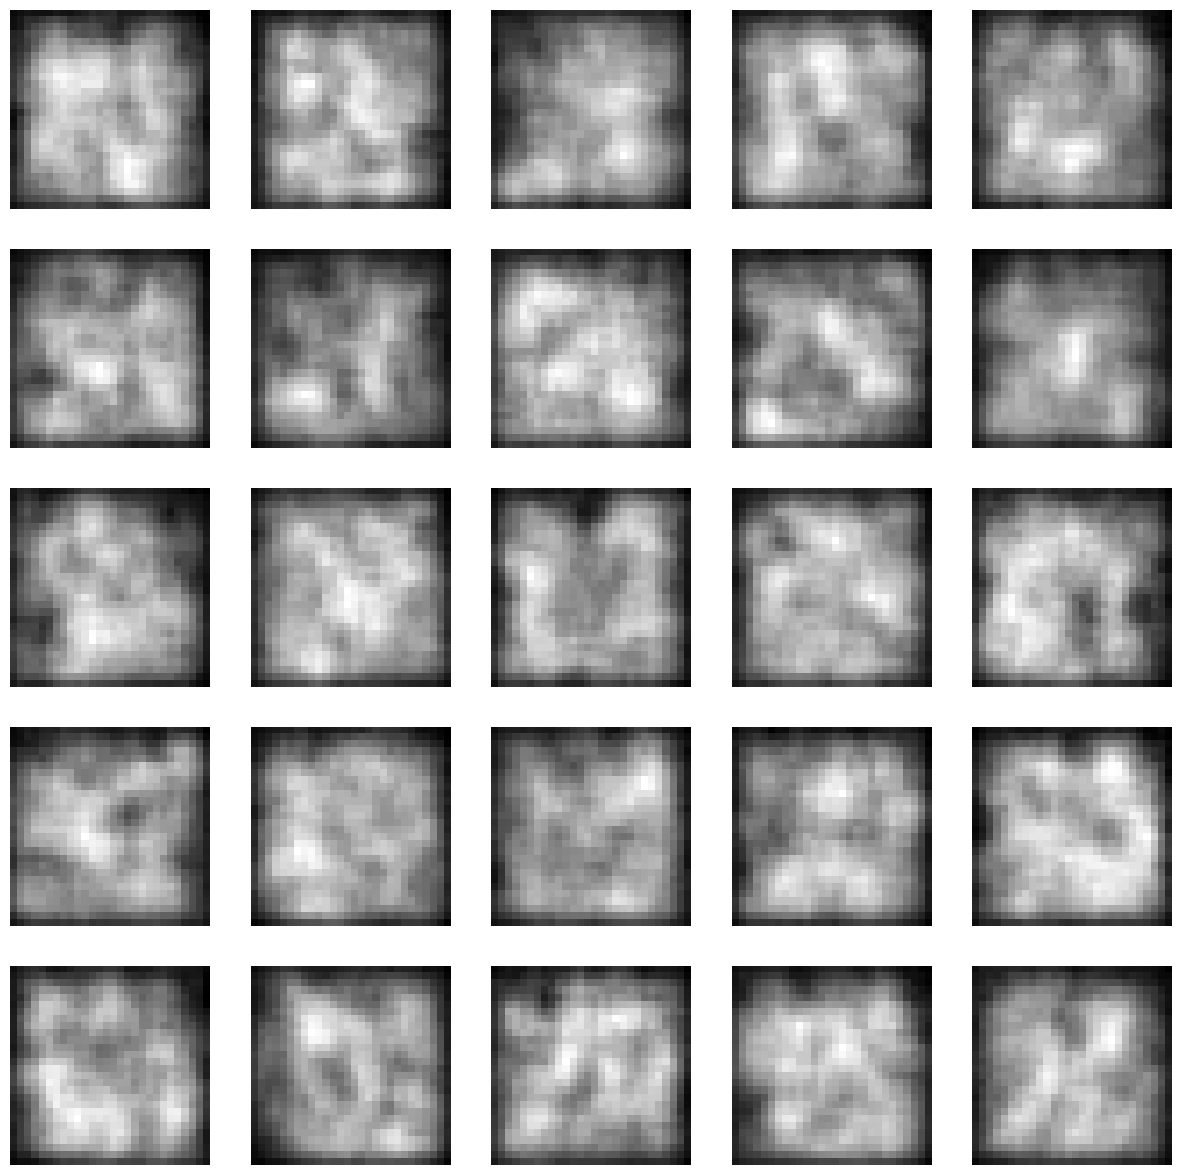

1 [D loss: (0.731)(R 0.664, F 0.797)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.685] [G acc: 1.000]
2 [D loss: (0.679)(R 0.657, F 0.700)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.655] [G acc: 1.000]
3 [D loss: (0.703)(R 0.492, F 0.913)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.561] [G acc: 1.000]
4 [D loss: (0.540)(R 0.287, F 0.792)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.122] [G acc: 1.000]
5 [D loss: (3.494)(R 0.020, F 6.968)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.556] [G acc: 1.000]
6 [D loss: (0.645)(R 0.543, F 0.746)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.505] [G acc: 1.000]
7 [D loss: (0.653)(R 0.517, F 0.790)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.492] [G acc: 1.000]
8 [D loss: (0.670)(R 0.509, F 0.830)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.483] [G acc: 1.000]
9 [D loss: (0.686)(R 0.505, F 0.867)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.491] [G acc: 1.000]
10 [D loss: (0.703)(R 0.511, F 0.895)] [D acc: (0.500)(1.000, 0.000)] [G loss: 0.522] [G acc: 1.000]

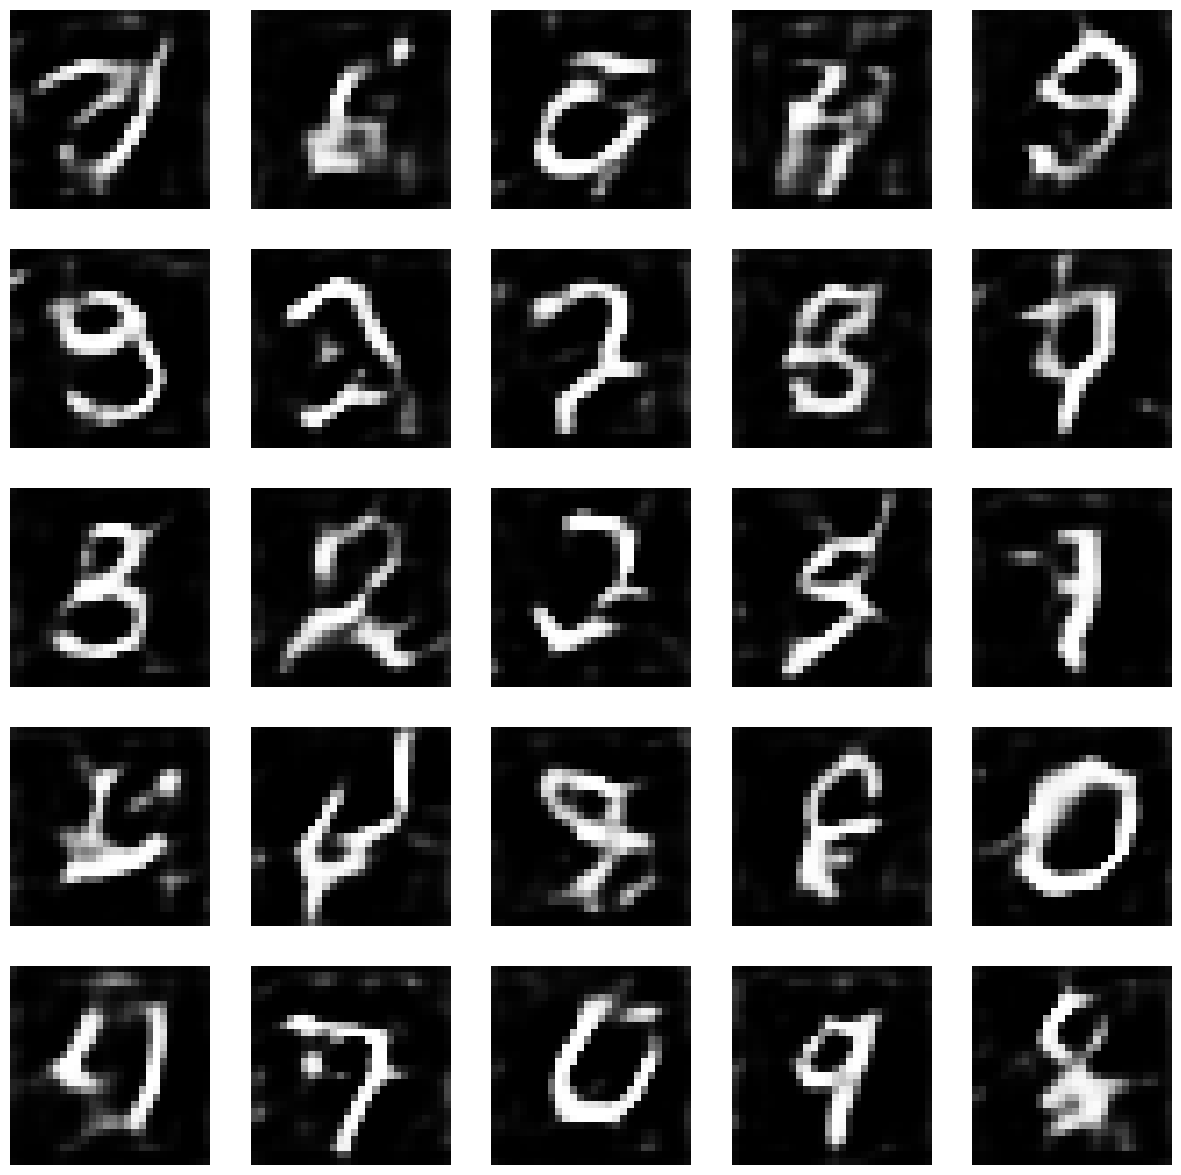

501 [D loss: (0.644)(R 0.629, F 0.659)] [D acc: (0.602)(0.562, 0.641)] [G loss: 0.872] [G acc: 0.234]
502 [D loss: (0.587)(R 0.512, F 0.662)] [D acc: (0.727)(0.719, 0.734)] [G loss: 0.897] [G acc: 0.203]
503 [D loss: (0.601)(R 0.530, F 0.671)] [D acc: (0.641)(0.703, 0.578)] [G loss: 0.934] [G acc: 0.188]
504 [D loss: (0.619)(R 0.562, F 0.676)] [D acc: (0.664)(0.672, 0.656)] [G loss: 0.900] [G acc: 0.281]
505 [D loss: (0.644)(R 0.571, F 0.718)] [D acc: (0.570)(0.641, 0.500)] [G loss: 0.932] [G acc: 0.281]
506 [D loss: (0.649)(R 0.672, F 0.625)] [D acc: (0.648)(0.594, 0.703)] [G loss: 0.877] [G acc: 0.203]
507 [D loss: (0.652)(R 0.646, F 0.657)] [D acc: (0.570)(0.500, 0.641)] [G loss: 0.840] [G acc: 0.250]
508 [D loss: (0.637)(R 0.607, F 0.666)] [D acc: (0.648)(0.625, 0.672)] [G loss: 0.916] [G acc: 0.234]
509 [D loss: (0.634)(R 0.567, F 0.702)] [D acc: (0.617)(0.641, 0.594)] [G loss: 0.841] [G acc: 0.312]
510 [D loss: (0.645)(R 0.618, F 0.673)] [D acc: (0.586)(0.531, 0.641)] [G loss: 0.

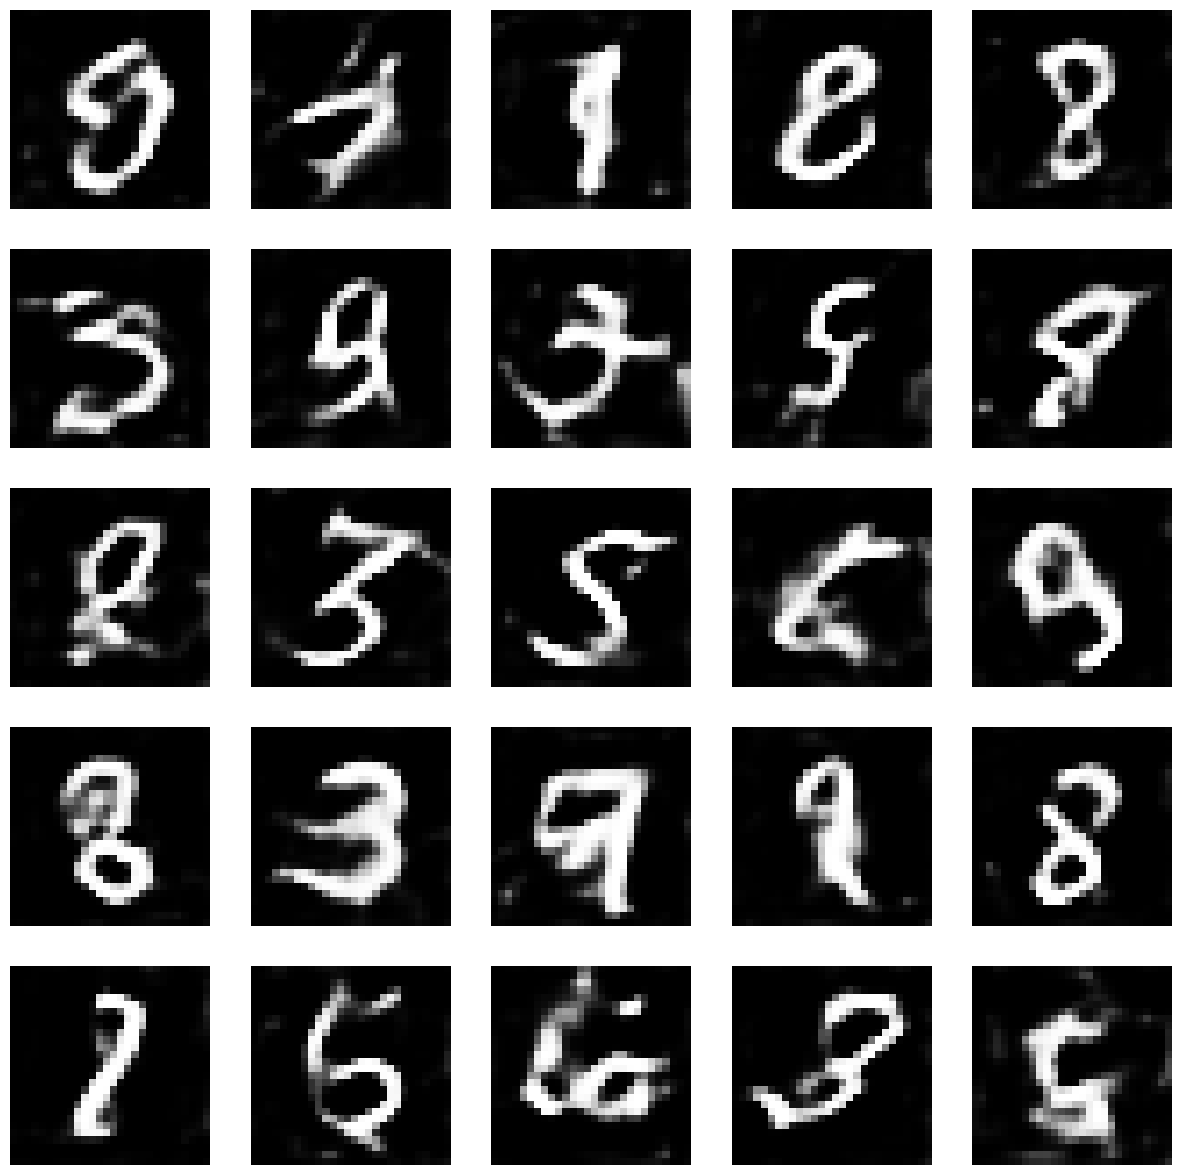

1001 [D loss: (0.611)(R 0.574, F 0.647)] [D acc: (0.680)(0.688, 0.672)] [G loss: 1.081] [G acc: 0.156]
1002 [D loss: (0.615)(R 0.566, F 0.664)] [D acc: (0.703)(0.672, 0.734)] [G loss: 0.985] [G acc: 0.219]
1003 [D loss: (0.594)(R 0.617, F 0.571)] [D acc: (0.609)(0.500, 0.719)] [G loss: 1.007] [G acc: 0.156]
1004 [D loss: (0.586)(R 0.590, F 0.582)] [D acc: (0.711)(0.656, 0.766)] [G loss: 0.948] [G acc: 0.234]
1005 [D loss: (0.573)(R 0.497, F 0.648)] [D acc: (0.766)(0.734, 0.797)] [G loss: 1.167] [G acc: 0.109]
1006 [D loss: (0.640)(R 0.619, F 0.661)] [D acc: (0.641)(0.578, 0.703)] [G loss: 1.114] [G acc: 0.109]
1007 [D loss: (0.592)(R 0.560, F 0.624)] [D acc: (0.695)(0.656, 0.734)] [G loss: 1.084] [G acc: 0.125]
1008 [D loss: (0.594)(R 0.548, F 0.640)] [D acc: (0.711)(0.672, 0.750)] [G loss: 1.048] [G acc: 0.141]
1009 [D loss: (0.563)(R 0.584, F 0.541)] [D acc: (0.680)(0.625, 0.734)] [G loss: 0.987] [G acc: 0.297]
1010 [D loss: (0.605)(R 0.586, F 0.623)] [D acc: (0.703)(0.609, 0.797)] [

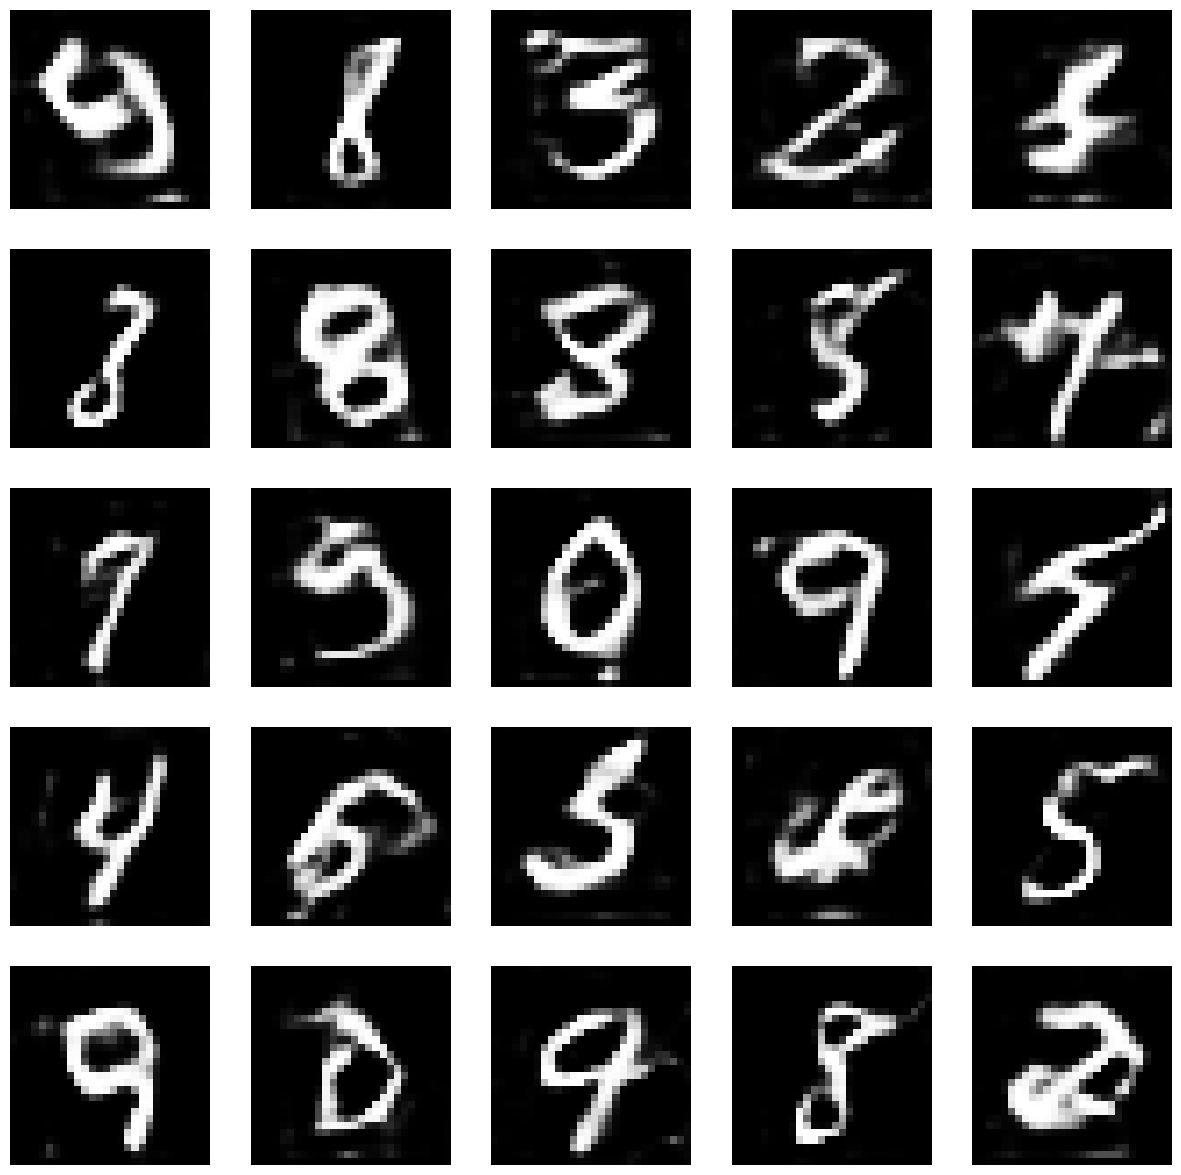

1501 [D loss: (0.602)(R 0.591, F 0.613)] [D acc: (0.695)(0.625, 0.766)] [G loss: 0.886] [G acc: 0.250]
1502 [D loss: (0.583)(R 0.549, F 0.616)] [D acc: (0.664)(0.625, 0.703)] [G loss: 0.980] [G acc: 0.203]
1503 [D loss: (0.688)(R 0.675, F 0.700)] [D acc: (0.555)(0.469, 0.641)] [G loss: 0.979] [G acc: 0.062]
1504 [D loss: (0.560)(R 0.538, F 0.582)] [D acc: (0.688)(0.641, 0.734)] [G loss: 1.032] [G acc: 0.125]
1505 [D loss: (0.607)(R 0.640, F 0.574)] [D acc: (0.672)(0.547, 0.797)] [G loss: 0.941] [G acc: 0.125]
1506 [D loss: (0.648)(R 0.688, F 0.608)] [D acc: (0.602)(0.484, 0.719)] [G loss: 1.017] [G acc: 0.109]
1507 [D loss: (0.627)(R 0.606, F 0.647)] [D acc: (0.688)(0.562, 0.812)] [G loss: 0.911] [G acc: 0.219]
1508 [D loss: (0.631)(R 0.645, F 0.616)] [D acc: (0.656)(0.516, 0.797)] [G loss: 0.931] [G acc: 0.250]
1509 [D loss: (0.638)(R 0.621, F 0.656)] [D acc: (0.633)(0.531, 0.734)] [G loss: 0.913] [G acc: 0.203]
1510 [D loss: (0.577)(R 0.581, F 0.574)] [D acc: (0.711)(0.609, 0.812)] [

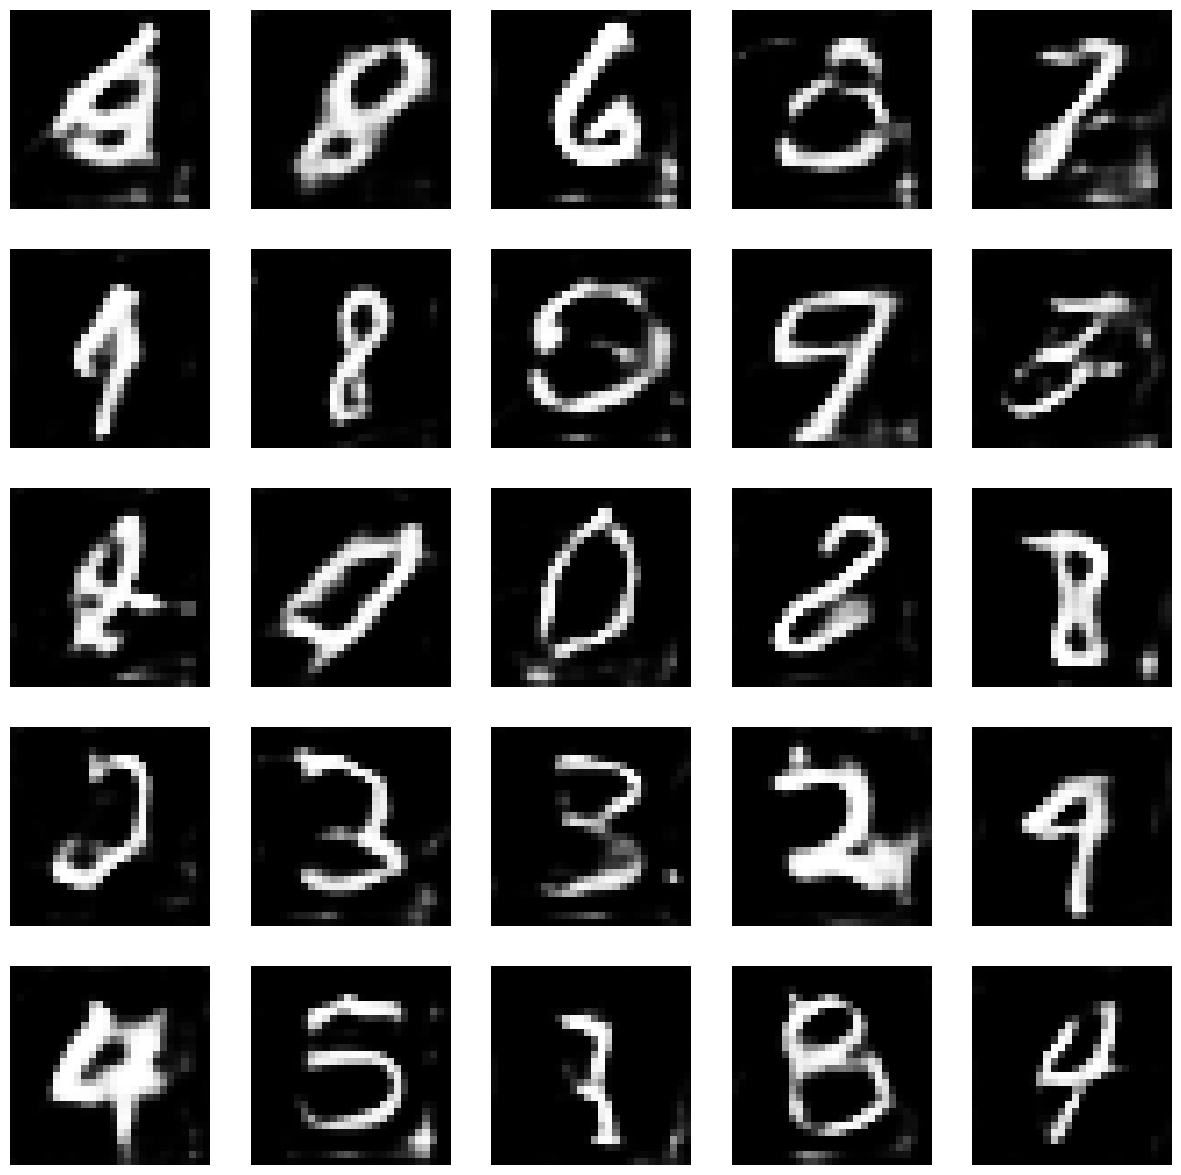

2001 [D loss: (0.639)(R 0.623, F 0.656)] [D acc: (0.641)(0.594, 0.688)] [G loss: 1.006] [G acc: 0.125]
2002 [D loss: (0.676)(R 0.622, F 0.729)] [D acc: (0.617)(0.500, 0.734)] [G loss: 1.020] [G acc: 0.125]
2003 [D loss: (0.647)(R 0.652, F 0.641)] [D acc: (0.625)(0.531, 0.719)] [G loss: 1.027] [G acc: 0.125]
2004 [D loss: (0.626)(R 0.569, F 0.684)] [D acc: (0.711)(0.641, 0.781)] [G loss: 1.052] [G acc: 0.109]
2005 [D loss: (0.589)(R 0.620, F 0.559)] [D acc: (0.656)(0.484, 0.828)] [G loss: 1.036] [G acc: 0.141]
2006 [D loss: (0.602)(R 0.641, F 0.564)] [D acc: (0.648)(0.547, 0.750)] [G loss: 0.930] [G acc: 0.297]
2007 [D loss: (0.604)(R 0.633, F 0.575)] [D acc: (0.648)(0.516, 0.781)] [G loss: 0.990] [G acc: 0.203]
2008 [D loss: (0.643)(R 0.550, F 0.735)] [D acc: (0.617)(0.594, 0.641)] [G loss: 0.997] [G acc: 0.219]
2009 [D loss: (0.628)(R 0.661, F 0.594)] [D acc: (0.648)(0.562, 0.734)] [G loss: 1.018] [G acc: 0.172]
2010 [D loss: (0.615)(R 0.609, F 0.621)] [D acc: (0.680)(0.594, 0.766)] [

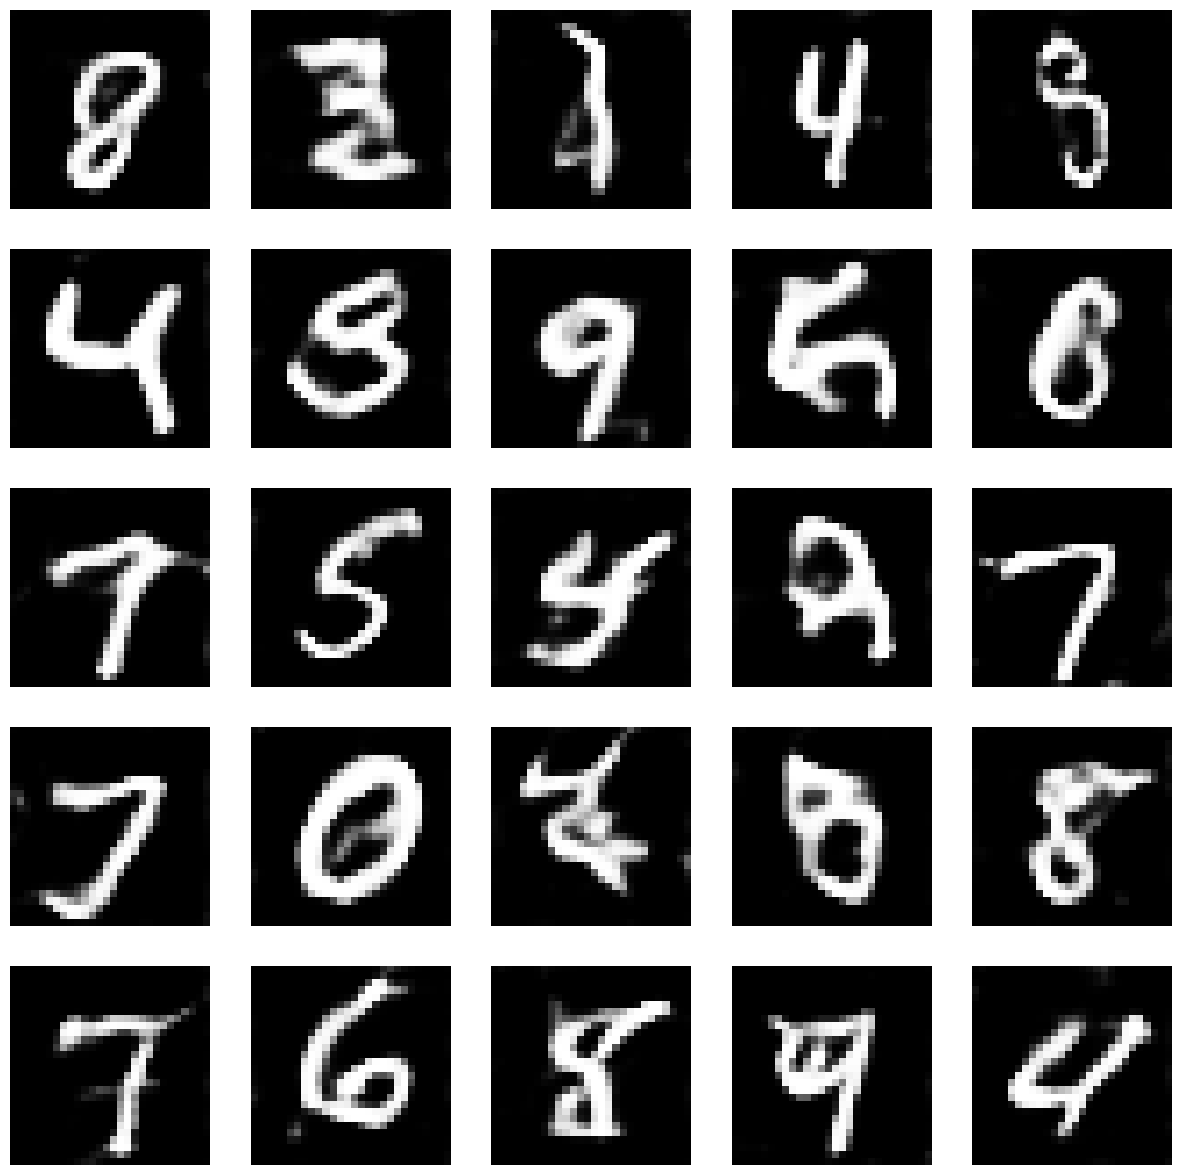

2501 [D loss: (0.631)(R 0.699, F 0.564)] [D acc: (0.617)(0.469, 0.766)] [G loss: 0.937] [G acc: 0.234]
2502 [D loss: (0.618)(R 0.659, F 0.577)] [D acc: (0.656)(0.578, 0.734)] [G loss: 0.914] [G acc: 0.250]
2503 [D loss: (0.582)(R 0.569, F 0.596)] [D acc: (0.727)(0.672, 0.781)] [G loss: 0.918] [G acc: 0.250]
2504 [D loss: (0.760)(R 0.725, F 0.794)] [D acc: (0.570)(0.438, 0.703)] [G loss: 0.991] [G acc: 0.188]
2505 [D loss: (0.643)(R 0.645, F 0.641)] [D acc: (0.625)(0.484, 0.766)] [G loss: 0.893] [G acc: 0.250]
2506 [D loss: (0.606)(R 0.637, F 0.574)] [D acc: (0.688)(0.562, 0.812)] [G loss: 0.919] [G acc: 0.219]
2507 [D loss: (0.601)(R 0.582, F 0.620)] [D acc: (0.688)(0.641, 0.734)] [G loss: 0.929] [G acc: 0.266]
2508 [D loss: (0.639)(R 0.588, F 0.691)] [D acc: (0.648)(0.641, 0.656)] [G loss: 1.006] [G acc: 0.234]
2509 [D loss: (0.605)(R 0.591, F 0.620)] [D acc: (0.664)(0.625, 0.703)] [G loss: 0.958] [G acc: 0.188]
2510 [D loss: (0.638)(R 0.697, F 0.579)] [D acc: (0.609)(0.484, 0.734)] [

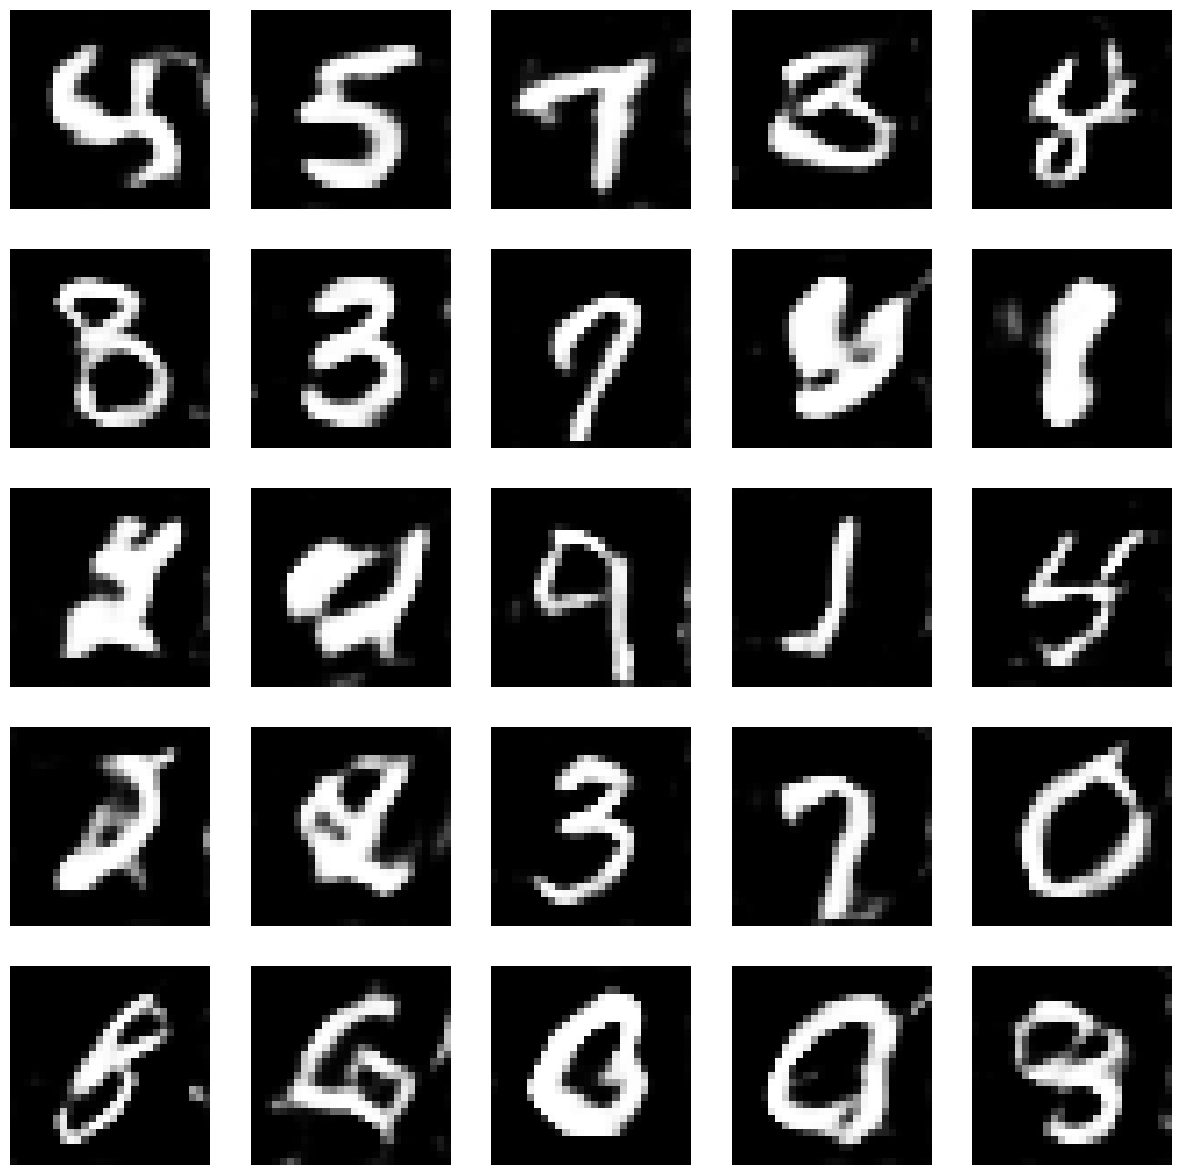

3001 [D loss: (0.676)(R 0.592, F 0.760)] [D acc: (0.633)(0.609, 0.656)] [G loss: 0.951] [G acc: 0.281]
3002 [D loss: (0.619)(R 0.642, F 0.596)] [D acc: (0.648)(0.547, 0.750)] [G loss: 1.007] [G acc: 0.172]
3003 [D loss: (0.639)(R 0.672, F 0.605)] [D acc: (0.664)(0.547, 0.781)] [G loss: 1.136] [G acc: 0.172]
3004 [D loss: (0.716)(R 0.646, F 0.785)] [D acc: (0.531)(0.484, 0.578)] [G loss: 0.951] [G acc: 0.219]
3005 [D loss: (0.625)(R 0.626, F 0.625)] [D acc: (0.656)(0.594, 0.719)] [G loss: 1.009] [G acc: 0.172]
3006 [D loss: (0.611)(R 0.628, F 0.595)] [D acc: (0.609)(0.531, 0.688)] [G loss: 1.014] [G acc: 0.125]
3007 [D loss: (0.655)(R 0.684, F 0.626)] [D acc: (0.609)(0.500, 0.719)] [G loss: 0.877] [G acc: 0.297]
3008 [D loss: (0.639)(R 0.647, F 0.631)] [D acc: (0.617)(0.562, 0.672)] [G loss: 0.916] [G acc: 0.266]
3009 [D loss: (0.674)(R 0.737, F 0.612)] [D acc: (0.539)(0.328, 0.750)] [G loss: 0.885] [G acc: 0.250]
3010 [D loss: (0.636)(R 0.530, F 0.741)] [D acc: (0.680)(0.703, 0.656)] [

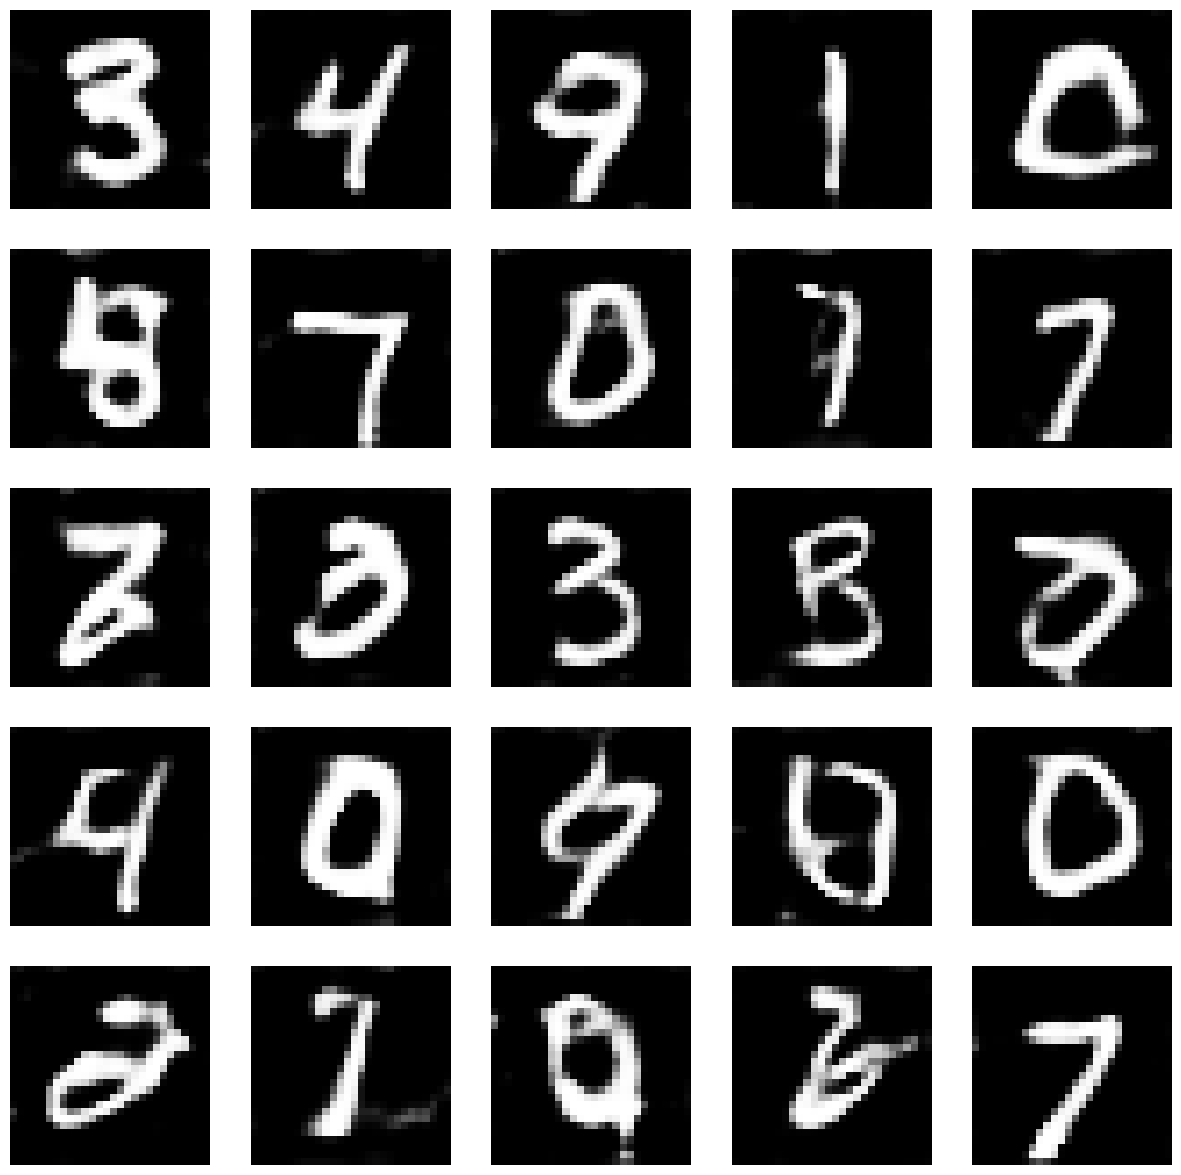

3501 [D loss: (0.609)(R 0.659, F 0.558)] [D acc: (0.672)(0.562, 0.781)] [G loss: 0.964] [G acc: 0.234]
3502 [D loss: (0.769)(R 0.653, F 0.885)] [D acc: (0.539)(0.531, 0.547)] [G loss: 0.979] [G acc: 0.188]
3503 [D loss: (0.619)(R 0.608, F 0.630)] [D acc: (0.633)(0.594, 0.672)] [G loss: 0.933] [G acc: 0.281]
3504 [D loss: (0.602)(R 0.574, F 0.630)] [D acc: (0.656)(0.625, 0.688)] [G loss: 0.989] [G acc: 0.172]
3505 [D loss: (0.609)(R 0.593, F 0.626)] [D acc: (0.672)(0.609, 0.734)] [G loss: 0.991] [G acc: 0.203]
3506 [D loss: (0.614)(R 0.665, F 0.563)] [D acc: (0.625)(0.469, 0.781)] [G loss: 0.976] [G acc: 0.234]
3507 [D loss: (0.629)(R 0.632, F 0.627)] [D acc: (0.672)(0.641, 0.703)] [G loss: 0.998] [G acc: 0.250]
3508 [D loss: (0.617)(R 0.576, F 0.658)] [D acc: (0.633)(0.641, 0.625)] [G loss: 0.910] [G acc: 0.266]
3509 [D loss: (0.592)(R 0.587, F 0.597)] [D acc: (0.656)(0.625, 0.688)] [G loss: 1.013] [G acc: 0.203]
3510 [D loss: (0.632)(R 0.628, F 0.637)] [D acc: (0.609)(0.547, 0.672)] [

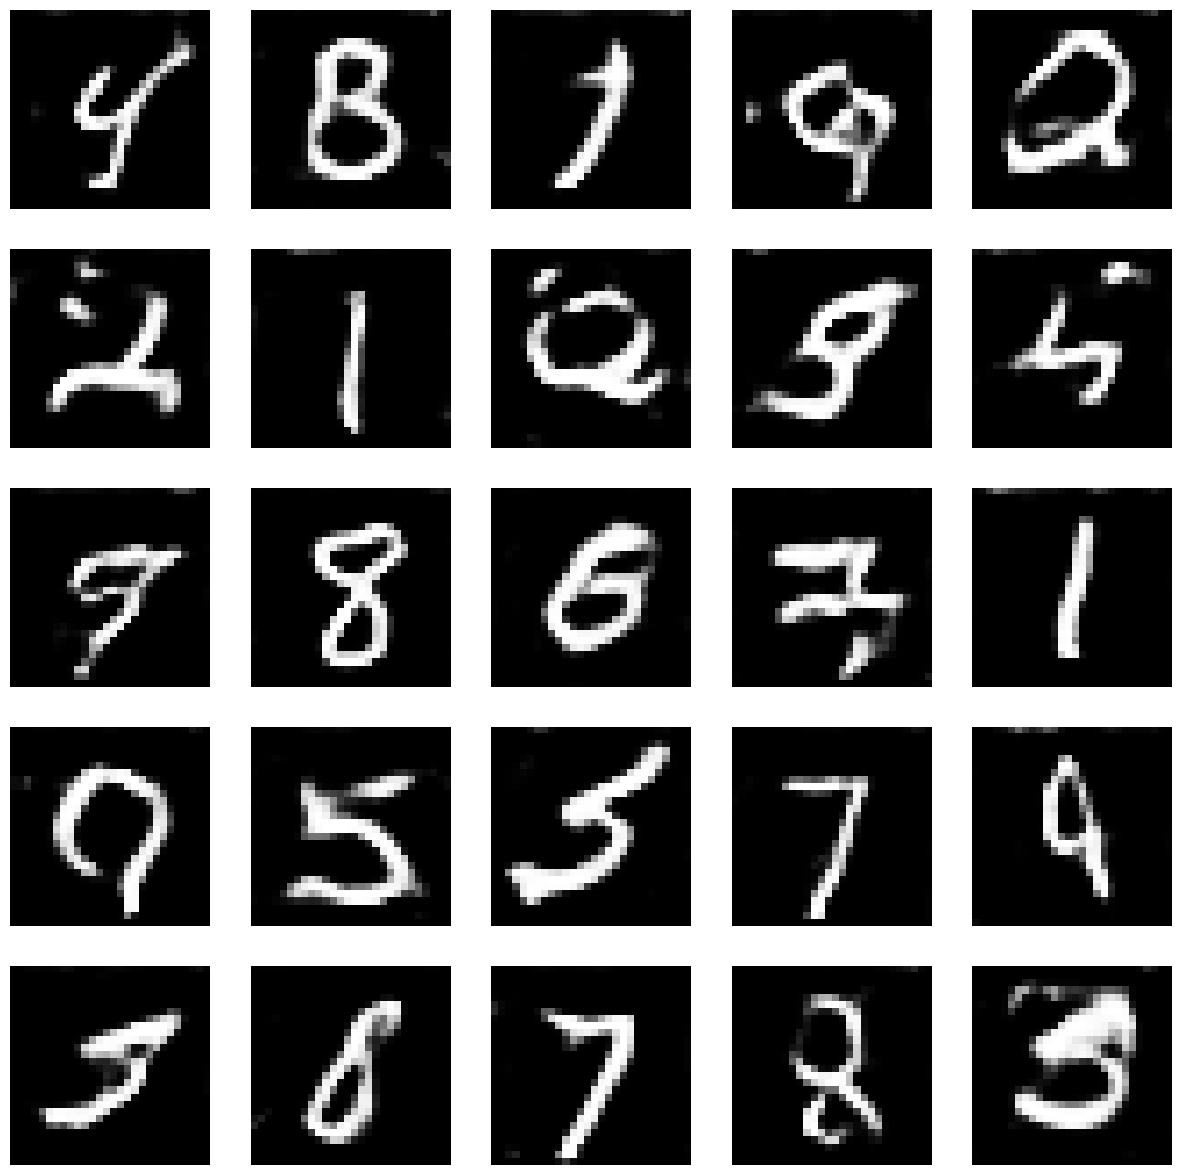

4001 [D loss: (0.579)(R 0.597, F 0.561)] [D acc: (0.664)(0.562, 0.766)] [G loss: 0.948] [G acc: 0.188]
4002 [D loss: (0.664)(R 0.686, F 0.643)] [D acc: (0.633)(0.547, 0.719)] [G loss: 0.894] [G acc: 0.219]
4003 [D loss: (0.667)(R 0.653, F 0.681)] [D acc: (0.578)(0.547, 0.609)] [G loss: 0.900] [G acc: 0.141]
4004 [D loss: (0.667)(R 0.685, F 0.649)] [D acc: (0.602)(0.469, 0.734)] [G loss: 0.894] [G acc: 0.234]
4005 [D loss: (0.628)(R 0.708, F 0.548)] [D acc: (0.578)(0.391, 0.766)] [G loss: 0.840] [G acc: 0.312]
4006 [D loss: (0.644)(R 0.621, F 0.667)] [D acc: (0.594)(0.500, 0.688)] [G loss: 0.963] [G acc: 0.266]
4007 [D loss: (0.611)(R 0.599, F 0.623)] [D acc: (0.680)(0.641, 0.719)] [G loss: 0.936] [G acc: 0.141]
4008 [D loss: (0.603)(R 0.627, F 0.580)] [D acc: (0.688)(0.594, 0.781)] [G loss: 0.978] [G acc: 0.188]
4009 [D loss: (0.644)(R 0.662, F 0.626)] [D acc: (0.617)(0.578, 0.656)] [G loss: 0.842] [G acc: 0.359]
4010 [D loss: (0.650)(R 0.619, F 0.681)] [D acc: (0.664)(0.562, 0.766)] [

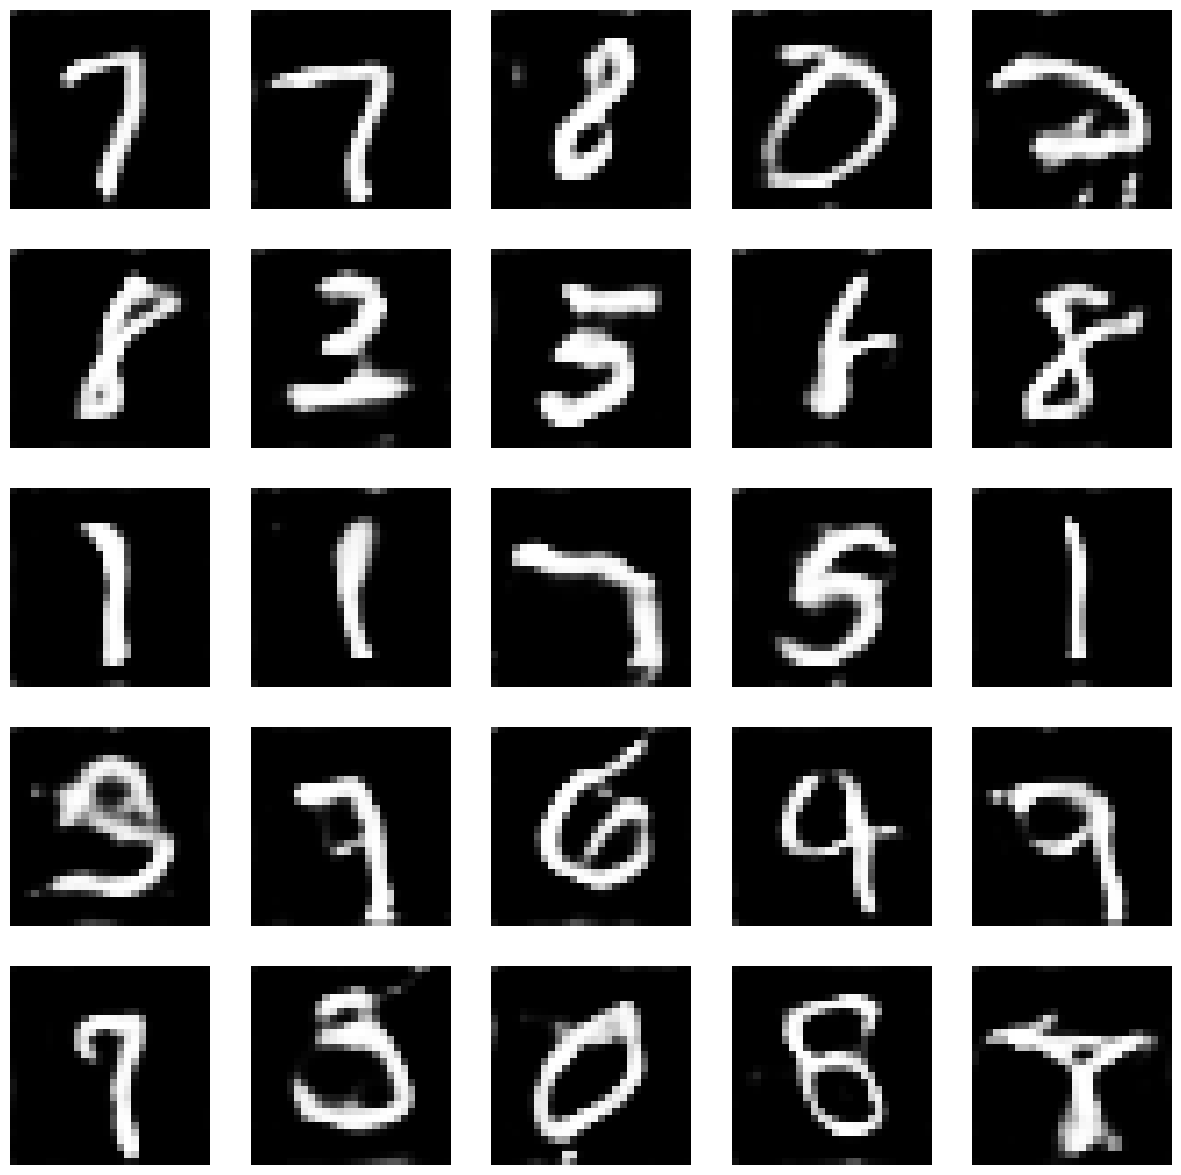

4501 [D loss: (0.695)(R 0.673, F 0.718)] [D acc: (0.602)(0.547, 0.656)] [G loss: 0.901] [G acc: 0.203]
4502 [D loss: (0.719)(R 0.731, F 0.706)] [D acc: (0.586)(0.484, 0.688)] [G loss: 0.826] [G acc: 0.234]
4503 [D loss: (0.651)(R 0.700, F 0.602)] [D acc: (0.586)(0.406, 0.766)] [G loss: 0.889] [G acc: 0.203]
4504 [D loss: (0.643)(R 0.685, F 0.602)] [D acc: (0.586)(0.469, 0.703)] [G loss: 0.929] [G acc: 0.156]
4505 [D loss: (0.641)(R 0.636, F 0.646)] [D acc: (0.664)(0.578, 0.750)] [G loss: 0.896] [G acc: 0.250]
4506 [D loss: (0.692)(R 0.698, F 0.687)] [D acc: (0.625)(0.516, 0.734)] [G loss: 0.948] [G acc: 0.125]
4507 [D loss: (0.644)(R 0.647, F 0.640)] [D acc: (0.648)(0.547, 0.750)] [G loss: 0.887] [G acc: 0.172]
4508 [D loss: (0.635)(R 0.699, F 0.571)] [D acc: (0.609)(0.438, 0.781)] [G loss: 0.933] [G acc: 0.203]
4509 [D loss: (0.678)(R 0.675, F 0.681)] [D acc: (0.633)(0.562, 0.703)] [G loss: 0.884] [G acc: 0.234]
4510 [D loss: (0.619)(R 0.655, F 0.583)] [D acc: (0.586)(0.484, 0.688)] [

In [88]:
(x_train, y_train), (x_test, y_test) = load_mnist_gan()

gan = GAN(input_dim = (28,28,1)
        , discriminator_conv_filters = [64,64,128,128]
        , discriminator_conv_kernel_size = [5,5,5,5]
        , discriminator_conv_strides = [2,2,2,1]
        , discriminator_batch_norm_momentum = None
        , discriminator_activation = 'relu'
        , discriminator_dropout_rate = 0.4
        , discriminator_learning_rate = 0.0008
        , generator_initial_dense_layer_size = (7, 7, 64)
        , generator_upsample = [2,2, 1, 1]
        , generator_conv_filters = [128,64, 64,1]
        , generator_conv_kernel_size = [5,5,5,5]
        , generator_conv_strides = [1,1, 1, 1]
        , generator_batch_norm_momentum = 0.9
        , generator_activation = 'relu'
        , generator_dropout_rate = None
        , generator_learning_rate = 0.0004
        , optimiser = 'rmsprop'
        , z_dim = 100
        )

gan.discriminator.summary()
gan.generator.summary()

batch_size = 64
epochs = 5000
print_frequency = 500

gan.train(x_train, batch_size = batch_size,epochs = epochs,
          print_every_n_batches = print_frequency)

Using the data collected from the training process, we can plot the progression of the loss and accuracy of the discriminator.

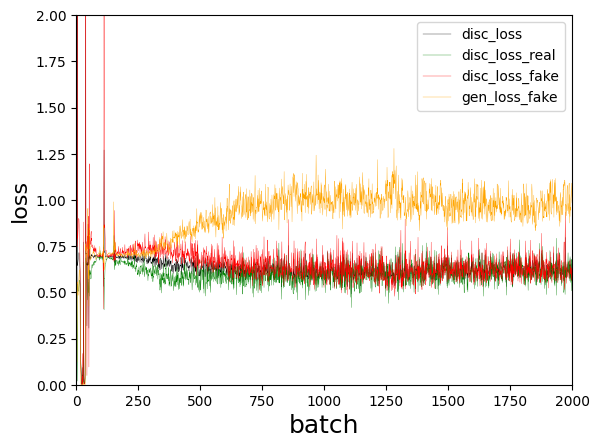

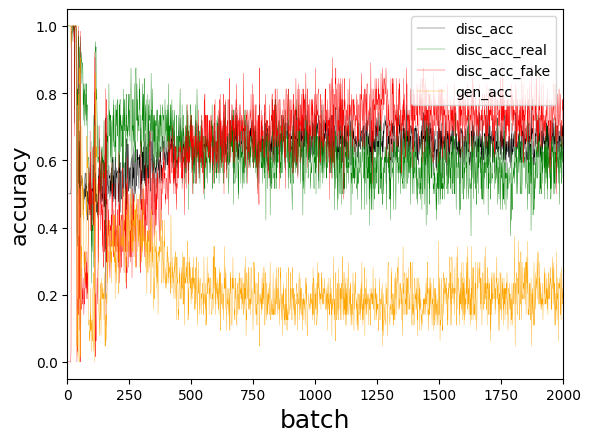

In [89]:
fig = plt.figure()
plt.plot([x[0] for x in gan.d_losses], color='black', linewidth=0.25,label='disc_loss')
plt.plot([x[1] for x in gan.d_losses], color='green', linewidth=0.25,label='disc_loss_real')
plt.plot([x[2] for x in gan.d_losses], color='red', linewidth=0.25,label='disc_loss_fake')
plt.plot([x[0] for x in gan.g_losses], color='orange', linewidth=0.25,label='gen_loss_fake')
plt.xlabel('batch', fontsize=18)
plt.ylabel('loss', fontsize=16)
plt.xlim(0, 2000)
plt.ylim(0, 2)
plt.legend()
plt.show()


fig = plt.figure()
plt.plot([x[3] for x in gan.d_losses], color='black', linewidth=0.25,label='disc_acc')
plt.plot([x[4] for x in gan.d_losses], color='green', linewidth=0.25,label='disc_acc_real')
plt.plot([x[5] for x in gan.d_losses], color='red', linewidth=0.25,label='disc_acc_fake')
plt.plot([x[1] for x in gan.g_losses], color='orange', linewidth=0.25,label='gen_acc')
plt.xlabel('batch', fontsize=18)
plt.ylabel('accuracy', fontsize=16)
plt.xlim(0, 2000)
plt.legend()

**2.1.1.** Analyze the result obtained in terms of the quality of the reconstruction and the stability/convergence of the training process.

#Quanto ao primeiro gráfico:

Por volta da batch 250, todas as losses se estabilizam um pouco, havendo a partir daí apenas alguns picos. O que apresenta uma maior loss é gen_loss_fake o que nos indica que há dificuldade em enganar o discrimandor. Já para disc_loss os valores são mais baixos, o que indica que está a ser conseguida uma boa distinção entre o real e o falso. Agora para disc_loss_real e disc_loss_fake, também apresentam valores mais baixos e estáveis, o que quer dizer que o discriminador está a conseguir distinguir de forma correta os dados reais como reais e o dados falsos como falsos, respetivamente.

#Quanto ao segundo gráfico:
De igual modo os valores também se começam a establizar por volta da batch 200 e observamos apenas alguns picos. Começando pelo valores de accuracy mais baixos, um gen_acc baixo indica que há dificuldade em gerar dados diferentes dos reais (classificados pelo discriminador). Quanto ao valor de disc_acc este é bom, o que quer dizer que há sucesso em distinguir dados reais de falsos. Para disc_acc_real e disc_acc_fake, os valores também são bons o que nos diz que o discriminador está a classificar corretamente os dados reais como reais e os dados falsos como falsos, respetivamente.


### 3. Testing the Wasserstein-GAN

The Wasserstein GAN (WGAN) is a variant of the original model that introduces the Wasserstein distance as a metric for training. Unlike traditional GANs, WGANs optimize a critic (instead of the discriminator) to approximate the Wasserstein distance between the true data distribution and the generated distribution. Therefore, WGAN introduces changes to the **critic**, the corresponding **loss function**, the data **labels**, and the **training dynamics**.

**3.1.** Implement and train a WGAN using the same dataset. Evaluate the results and compare the performance of the two GAN implementations.